<a href="https://colab.research.google.com/github/interngithub2020/RF_modulation_classification/blob/master/time_series_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and aims of this notebook

This notebook aims to experiment with different common neural network architectures on modulation classification of time-series data (I/Q and amplitude-phase). The raw I/Q data comes from the 2016.10A dataset, and can be downloaded here:  https://www.deepsig.ai/datasets.

Note that most of the hyperparameters have not been optimised yet, but I hope that this notebook presents a good starting point for people working on the task of modulation classification using time-series data. 

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")
root_path = "/content/gdrive/My Drive/mod_rec/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#%reset
%tensorflow_version 1.x
from sklearn.externals import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Conv2D, Input, Concatenate, Add
from keras.layers.convolutional import Convolution1D ,Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.initializers import glorot_uniform
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from scipy.interpolate import UnivariateSpline
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.optimizers import Adam
from keras import regularizers


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Training parameters and helper functions

Here I set training parameters and helper functions used in common across all models. 

## Variables used for training the models



In [ ]:
EPOCHS = 100
NUM_CLASSES = 8
BATCH_SIZE = 1024
PATIENCE = 10

## Functions for data conversion

In [ ]:
#Normalisation is very important
def iq2ampphase(inphase, quad):
    amplitude = np.sqrt(np.square(inphase) + np.square(quad))
    amp_norm = np.linalg.norm(amplitude) #L2 norm
    amplitude = amplitude/amp_norm #normalise
    phase = np.arctan(np.divide(quad, inphase))
    phase = 2.*(phase - np.min(phase))/np.ptp(phase)-1 #rescale phase to range [-1, 1]
    return amplitude, phase

#convert array of multiple iq samples into array of multiple ampphase samples
def arr_iq2ap(X):
  X_ap = []
  for k in range(X.shape[0]):
    I = X[k][0,:]
    Q = X[k][1,:]
    amp, phase = iq2ampphase(I, Q)
    ap = np.array([amp, phase])
    X_ap.append(ap)
  X_ap = np.array(X_ap)
  return X_ap

## Functions for generating and plotting confusion matrices


In [ ]:
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size)
    y_hat_onehot = np.zeros_like(y_hat)
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(y.shape[0]):
        
        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]          
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix column wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[:,i]) > 0:
          confusion_mat[:,i] /= np.sum(confusion_mat[:,i])
    
    return confusion_mat,acc

 
import seaborn as sns
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
  
  plt.title(title)
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('Predicted label')
  plt.xlabel('True label')

## ModelEvaluater Class of functions for training and evaluation
(1) formatting label data into one-hot format,  

(2) fitting model with training data,

(3) evaluating model using accuracy plots and confusion matrices

During fitting, Model Checkpoints are set so that weights files are automatically saved when validation loss decreases. There is also earlystopping, for which the default patience is 10 epochs. 

During print_summary(), the model is evaluated on the test set and prints out the confusion matrices for different SNRs and a graph showing accuracy over different SNRs.

Example on using ModelEvaluater class: 

    fc_model = build_fc_net(X_test.shape[1],X_teat.shape[2])
    fc_model_evaluater = ModelEvaluater(fc_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE,  'fc-net' )
    fc_model_evaluater.fit(EPOCHS, patience=10)
    fc_model_evaluater.print_summary()


In [ ]:
class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_val, y_val, X_test, y_test,
               labels_test, batch_size, model_name, channels_first=True, feature_type=1):
    if channels_first:
      self.X_train = X_train
      self.X_val = X_val
      self.X_test = X_test
    else:
      self.X_train = X_train.reshape([X_train.shape[0], X_train.shape[2], X_train.shape[1]])
      self.X_val = X_val.reshape([X_val.shape[0], X_val.shape[2], X_val.shape[1]])
      self.X_test = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])
    
    self.feature_type = feature_type
      
    self.model = model
    self.y_train = y_train
    self.y_val = y_val
    self.y_test = y_test
    self.labels_test = labels_test
    self.model_name = model_name
    self._checkpoint_callback = ModelCheckpoint(filepath=root_path + '%s-weights-{epoch}.hdf5' % self.model_name,
                                                verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []
    
    self.batch_size = batch_size
    
    # get the modulation types into an array
    self.mod_types = np.unique(labels_test[:,0])
  
    # fit a label binarizer 
    self.mod_to_onehot = preprocessing.LabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)

    # transform the y values to one-hot encoding
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_val = self.mod_to_onehot.transform(y_val)
    self.y_test = self.mod_to_onehot.transform(y_test)
    
    print('y_train %s' %(y_train.shape))
    print('y_val %s' %(y_val.shape))
    print('y_test %s' %(y_test.shape))
    

    
  def fit(self, epochs, patience=10):
    curr_X, curr_y = self.X_train, self.y_train
    val_X, val_y = self.X_val, self.y_val
    callbacks = [self._checkpoint_callback, EarlyStopping(patience=patience)]
   
     # train the model
    model_info = self.model.fit(curr_X, curr_y,
                                batch_size=self.batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(val_X, val_y),
                                callbacks=callbacks)

    self._train_accs.extend(model_info.history['accuracy'])
    self._val_accs.extend(model_info.history['val_accuracy'])



  def print_summary(self):
    # plot validation accuracy vs training accuracy
    plt.plot(np.arange(len(self._train_accs)), self._train_accs, '-o', label='training accuracy')
    plt.plot(np.arange(len(self._val_accs)), self._val_accs, '-o', label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.title('%s -validation vs training accuracy' %(self.model_name))
    display(plt.show())

    #plot confusion matrix for all, low, med and high SNR
    snr_ranges = [(-20, 20), (-20, -11), (-10, 5), (6, 20)]
    for snr_rng in snr_ranges:
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

    # get accuracy per snr
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    # plot the accuracy against the snr
    plt.plot(list(snr_accs.keys()),list(snr_accs.values()))
    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.xticks(list(snr_accs.keys()))
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.grid(True)
    plt.show()


  def accpersnr_model(self):
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    return snr_accs

# Loading and formatting of data 

In a python script, I divided the radioML dataset into a train-val-test split of 0.67 - 0.13 - 0.2, and stored them in 'rml_trainvaltest.hdf5'. They have already been shuffled, so simply load them as below.

More information about the source:
The 2016.10A radioML dataset (download here https://www.deepsig.ai/datasets) is a python dictionary with keys (mod, SNR) and values being an array of samples of 2x128 time-series I/Q data. It contains 11 types of modulations of varying SNR, and also contains some simulated channel effects. Refer to [Radio Machine Learning Dataset Generation with GNU Radio](https://pubs.gnuradio.org/index.php/grcon/article/view/11) for more information on the dataset.

In [ ]:
from sklearn.externals import joblib
data = joblib.load(root_path + 'data/rml_trainvaltest.hdf5')

In [ ]:
#quick understanding of data
print(data.keys())
print('Train val test size: ', data['train']['X'].shape, data['val']['X'].shape, data['test']['X'].shape)
print('Check if data is shuffled: ', data['val']['labels'][:10])

uniq, counts = np.unique(data['train']['labels'][:,1], return_counts = True)
print('Check snr range: ', uniq)
print('Check distribution of samples across SNR: ', counts)

uniq, counts = np.unique(data['train']['labels'][:,0], return_counts = True)
print('Check modulation types: ', uniq)
print('Check distribution of samples across modulation types: ', counts)

dict_keys(['val', 'train', 'test'])
Train val test size:  (107200, 2, 128) (20800, 2, 128) (32000, 2, 128)
Check if data is shuffled:  [['d4PAM' '16']
 ['a16QAM' '0']
 ['cGFSK' '-20']
 ['dBPSK' '4']
 ['d4PAM' '-20']
 ['cCPFSK' '-2']
 ['dBPSK' '-4']
 ['d4PAM' '-16']
 ['a16QAM' '-20']
 ['a64QAM' '2']]
Check snr range:  ['-10' '-12' '-14' '-16' '-18' '-2' '-20' '-4' '-6' '-8' '0' '10' '12'
 '14' '16' '18' '2' '4' '6' '8']
Check distribution of samples across SNR:  [5422 5363 5335 5362 5333 5279 5310 5330 5316 5390 5436 5326 5334 5445
 5393 5385 5319 5399 5372 5351]
Check modulation types:  ['a16QAM' 'a64QAM' 'b8PSK' 'bQPSK' 'cCPFSK' 'cGFSK' 'd4PAM' 'dBPSK']
Check distribution of samples across modulation types:  [13373 13373 13401 13445 13452 13345 13502 13309]


## Load train, val, test data and convert to polar form

In [ ]:
#load data
X_train = data['train']['X']
y_train = data['train']['labels'][:,0]
labels_train = data['train']['labels'] 

X_val = data['val']['X']
y_val = data['val']['labels'][:,0]
labels_val = data['val']['labels'] 

X_test = data['test']['X']
y_test = data['test']['labels'][:,0]
labels_test = data['test']['labels'] 

In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

## Quick visualisation of IQ and AP data
Here we quickly visualise the I/Q and amp-phase data from the first 16 sample of X_train to get a feel of the dataset. To understand more about modulation schemes, the [Wikipedia page on modulation](https://en.wikipedia.org/wiki/Modulation) is a good starting point.

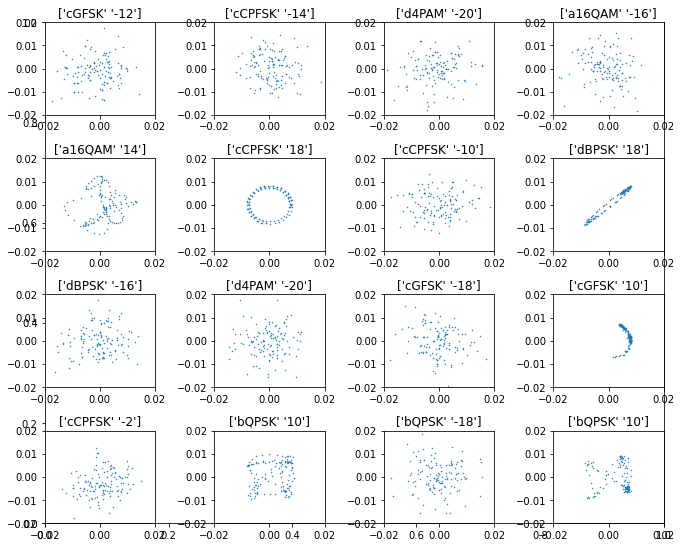

In [ ]:
#constellation diagrams
fig, ax = plt.subplots(figsize=(10,8)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    I = X_train[i][0,:]
    Q = X_train[i][1,:]
    plt.plot(I, Q, '.', markersize=1)
    plt.xlim(-0.02, 0.02)
    plt.ylim(-0.02, 0.02)
    plt.title(str(labels_train[i]))
    plt.tight_layout()
plt.show()

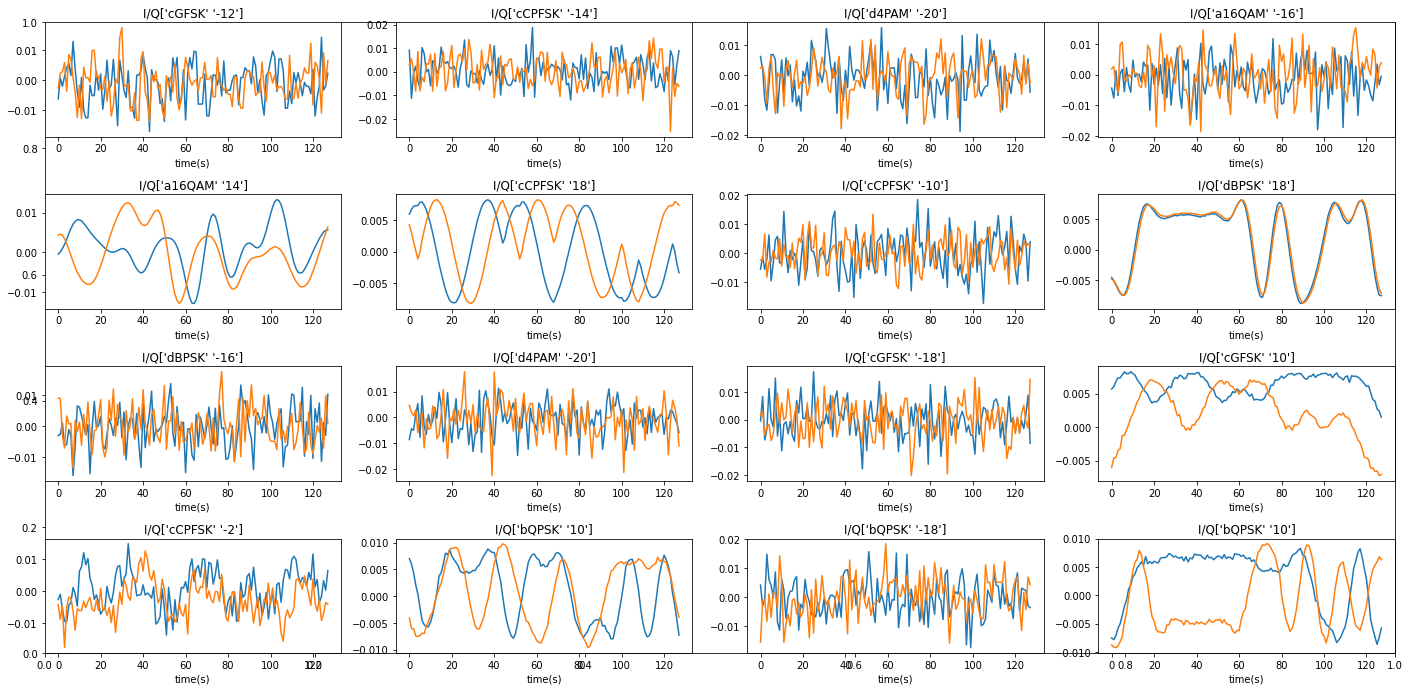

In [ ]:
#IQ time-series
fig, ax = plt.subplots(figsize=(20,10)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    I = X_train[i][0,:]
    Q = X_train[i][1,:]
    ax.set_xlabel('time(s)')
    ax.plot(I)
    ax.plot(Q)
    plt.title('I/Q' + str(labels_train[i]))
    plt.tight_layout()
plt.show()

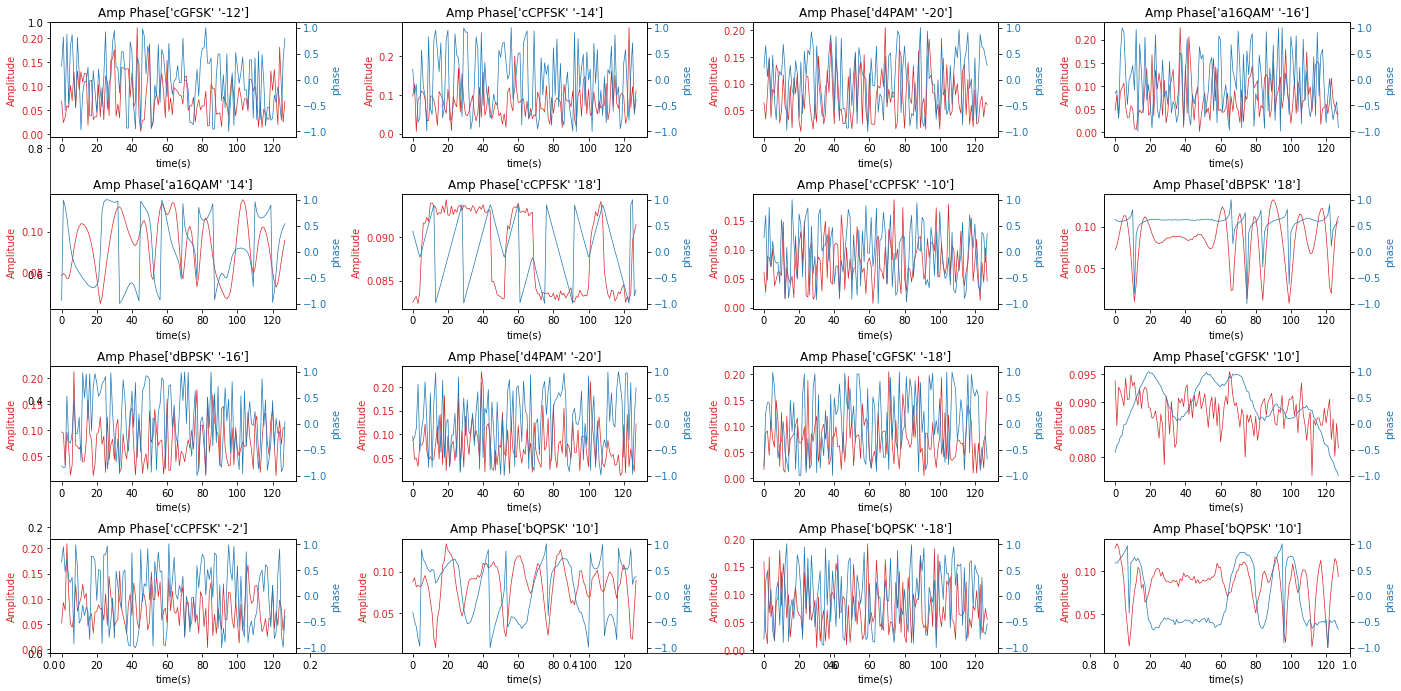

In [ ]:
#Amp-Phase time-series
fig, ax = plt.subplots(figsize=(20,10)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    amp = X_ap_train[i][0,:]
    phase = X_ap_train[i][1,:]
    ax.set_xlabel('time(s)')
    ax.set_ylabel('Amplitude',color='tab:red')
    ax.plot(amp, color='tab:red', linewidth=0.7)
    ax.tick_params(axis='y', labelcolor='tab:red')
    ax2 = ax.twinx()
    ax2.set_ylabel('phase', color='tab:blue')
    ax2.plot(phase, color='tab:blue', linewidth=0.7)
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    plt.title('Amp Phase' + str(labels_train[i]))
    plt.tight_layout()
plt.show()

# Training different models

I tried different forms of CNN and LSTMs shown to be quite successful in literature.

## Basic CNN: 2 conv + 2 dense
From [Convolutional Radio Modulation Recognition Networks](https://arxiv.org/abs/1602.04105)

This is a basic CNN with two convolutional layers followed by two dense layers, very typical architecture. The idea is that the convolutional filters can remove noise from the raw input, like how we do average filtering for signal processing, and the writers suggest that it could be similar to matched filters at receivers as well. The filter sizes were experimentally determined by the authors.


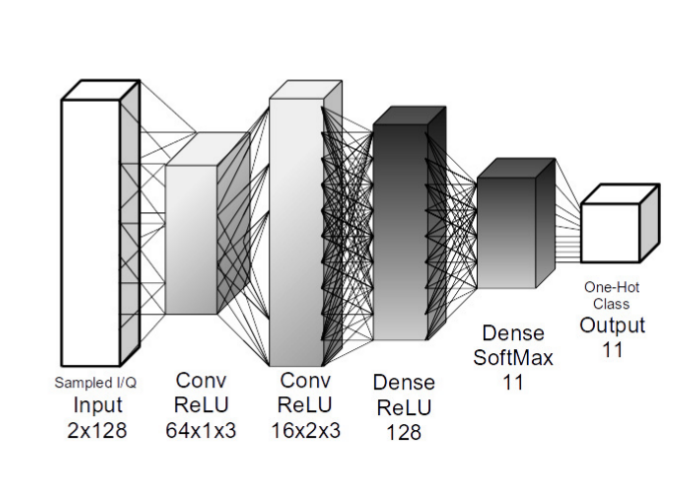

In [ ]:
def build_cnn_net(X1, X2):
    dr = 0.6 # dropout rate (%)
    
    cnn_model = Sequential()
    cnn_model.add(Reshape((1,X1, X2), input_shape=(X1, X2)))
    cnn_model.add(Convolution2D(256, (1,3), padding="valid", activation='relu', init='glorot_uniform', data_format="channels_first"))
    cnn_model.add(Dropout(dr))
    cnn_model.add(Convolution2D(80, (2, 3), padding="valid", activation='relu', init='glorot_uniform', data_format="channels_first"))
    cnn_model.add(Dropout(dr))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(256, activation='relu', init='he_normal'))
    cnn_model.add(Dropout(dr))
    cnn_model.add(Dense(NUM_CLASSES, activation='softmax', init='he_normal'))
    cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    cnn_model.summary()
    return cnn_model

### IQ training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="softmax", kernel_initializer="he_normal")`
  del sys.path[0]


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 2, 126)       1024      
_________________________________________________________________
dropout_15 (Dropout)         (None, 256, 2, 126)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 80, 1, 124)        122960    
_________________________________________________________________
dropout_16 (Dropout)         (None, 80, 1, 124)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9920)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

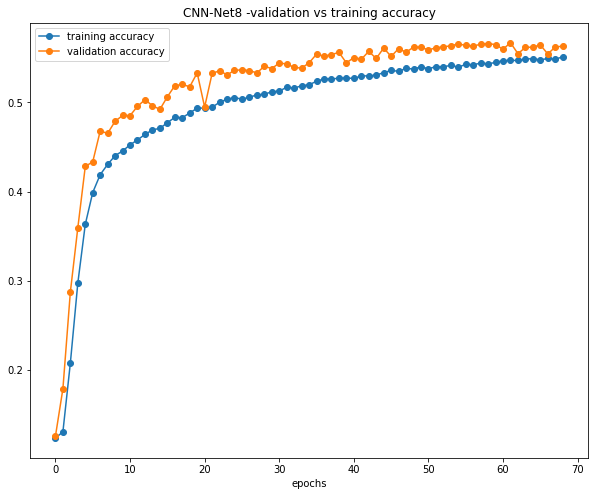

None

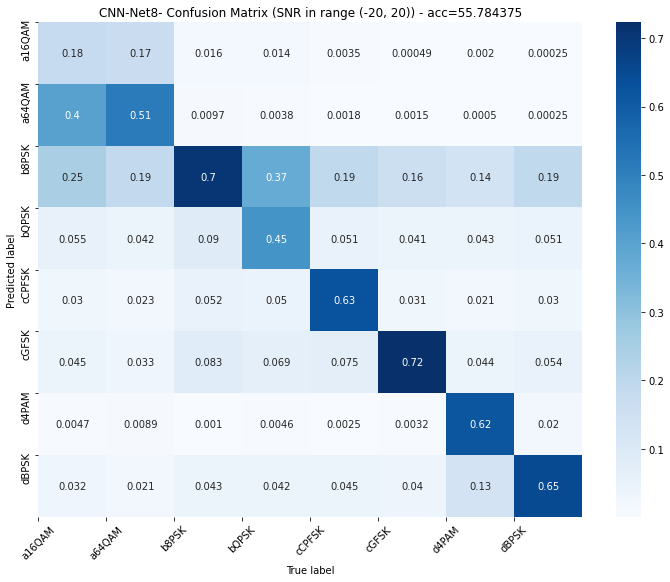

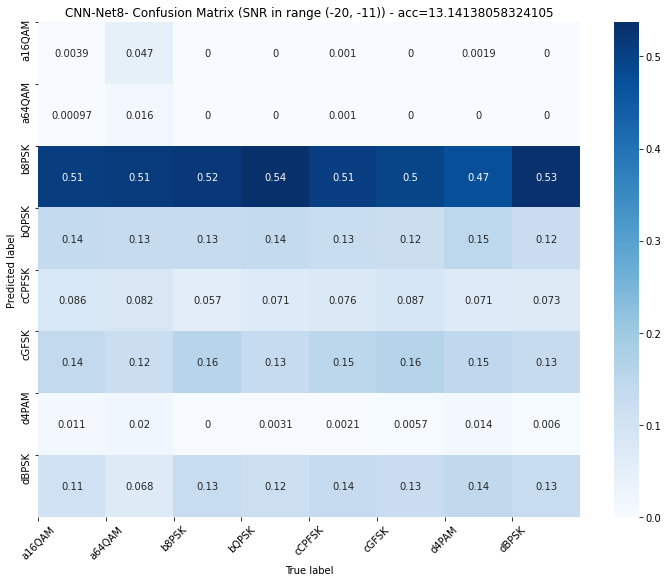

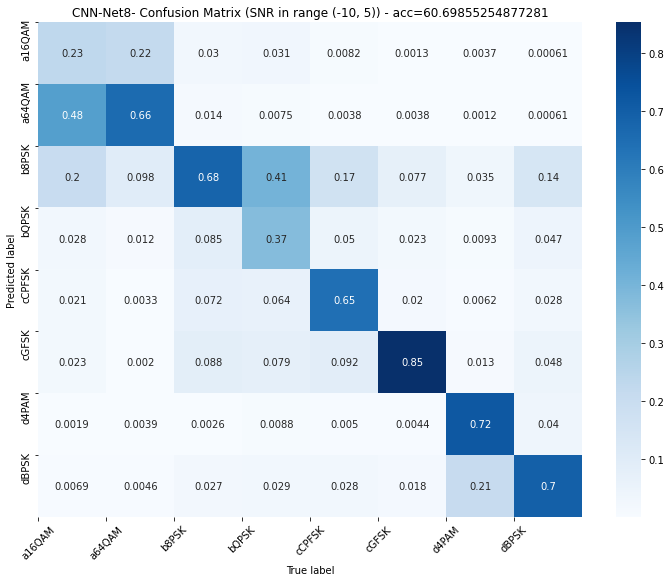

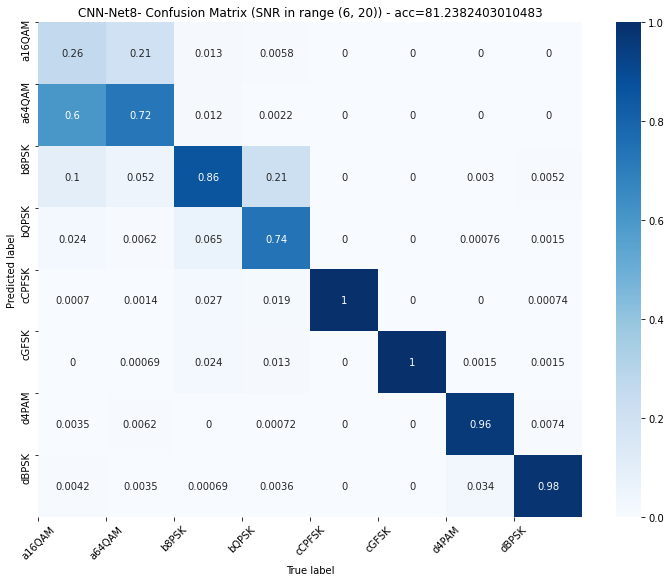

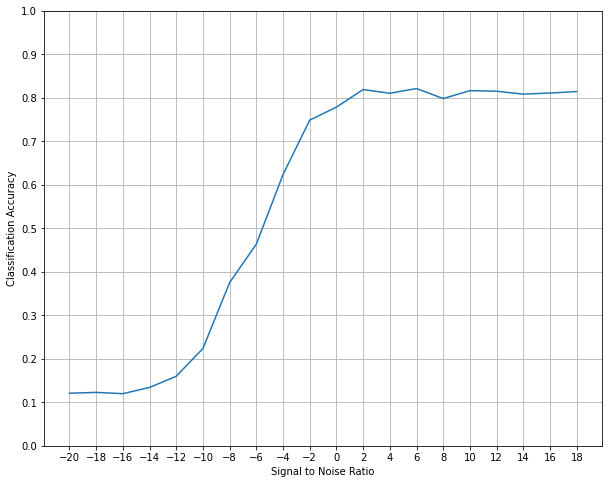

In [ ]:
cnn_model = build_cnn_net(X_test.shape[1], X_test.shape[2])
cnn_model_evaluater = ModelEvaluater(cnn_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE, 'CNN-Net8' )
cnn_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cnn_model_evaluater.print_summary()

The basic CNN gives pretty good performance at high SNRs, but have difficulties with QAMs and PSKs. This serves as the baseline for comparison for the other more sophisticated CNN architectures.

### AP Training
In [End-to-end Learning from Spectrum Data: A Deep Learning approach for Wireless Signal Identification in Spectrum Monitoring applications](http://arxiv.org/abs/1712.03987), it was found that training the basic CNN architecture with amplitude-phase data yielded better accuracy at high SNR, so here, we also try to train with amplitude-phase data to see if we obtain the same observation.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="softmax", kernel_initializer="he_normal")`
  del sys.path[0]


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 256, 2, 126)       1024      
_________________________________________________________________
dropout_24 (Dropout)         (None, 256, 2, 126)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 80, 1, 124)        122960    
_________________________________________________________________
dropout_25 (Dropout)         (None, 80, 1, 124)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9920)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)              

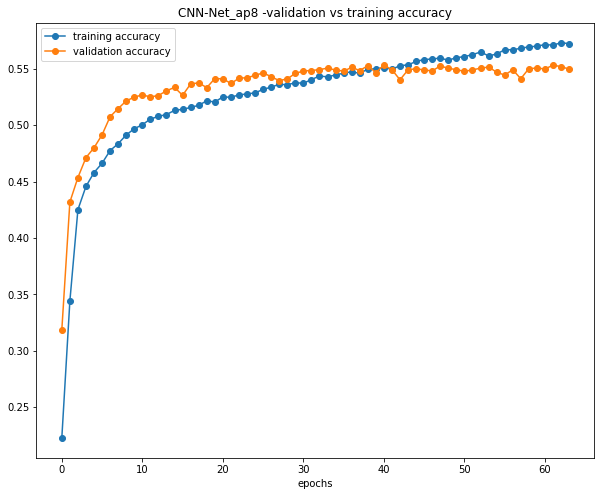

None

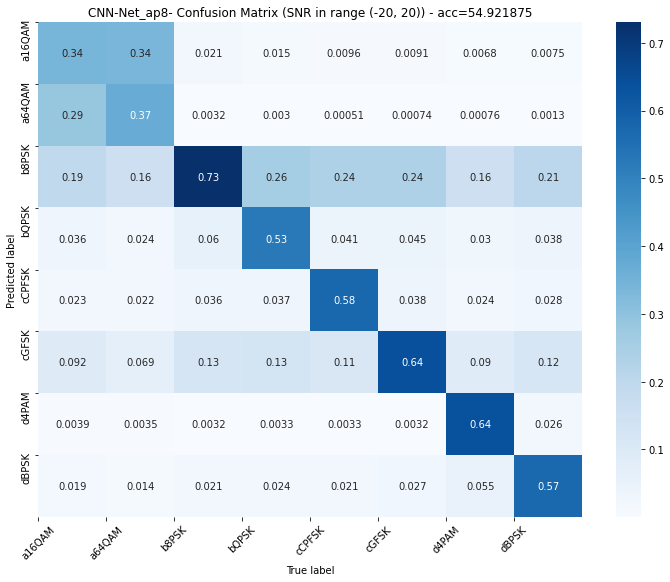

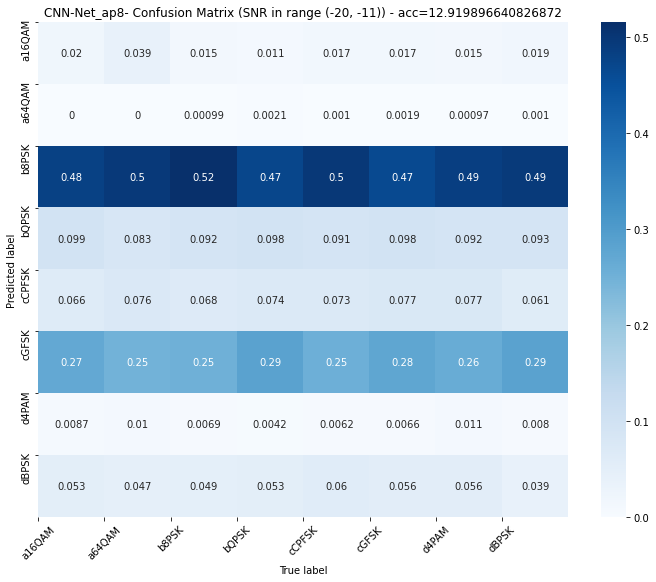

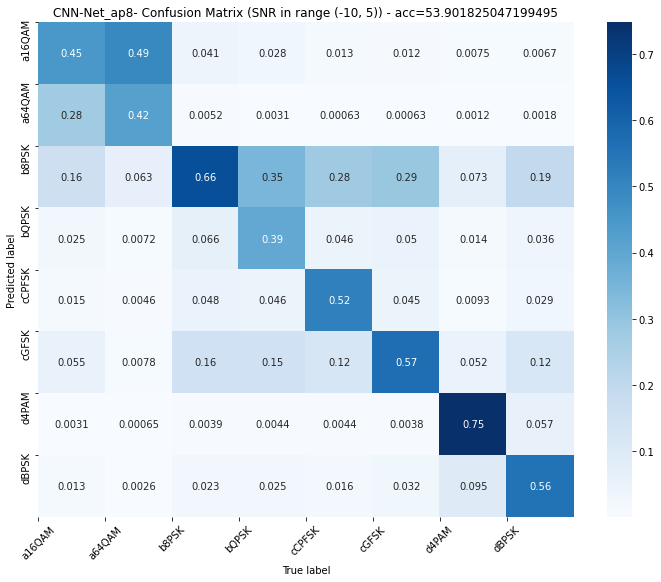

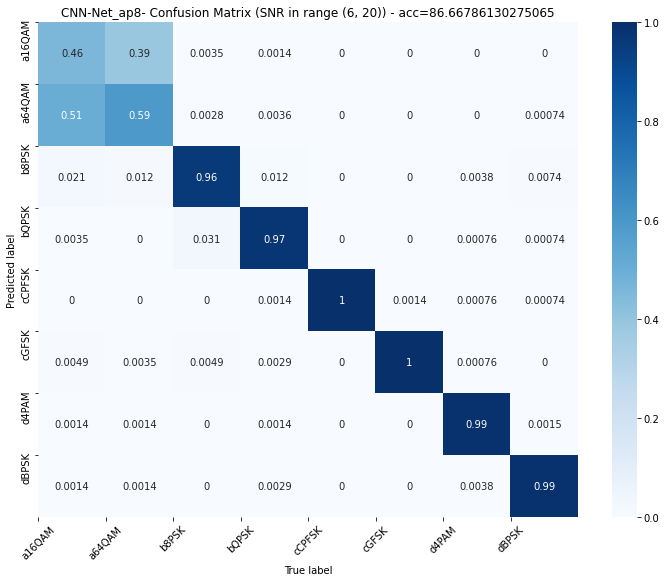

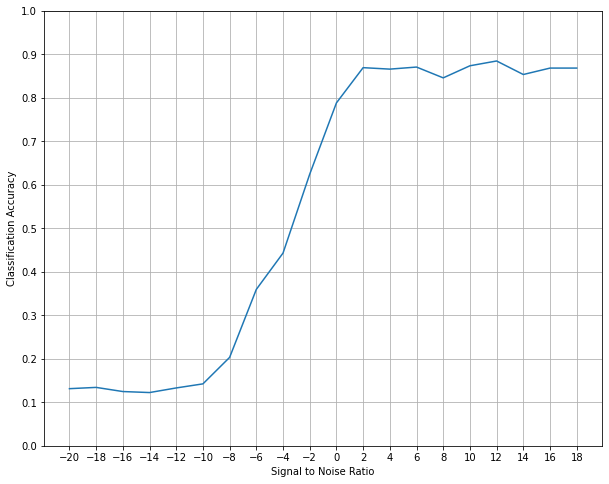

In [ ]:
cnn_ap_model = build_cnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cnn_ap_model_evaluater = ModelEvaluater(cnn_ap_model, X_ap_train, y_train, X_ap_val, y_val, X_ap_test, y_test, labels_test, BATCH_SIZE, 'CNN-Net_ap8' )
cnn_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cnn_ap_model_evaluater.print_summary()

Performance of the basic CNN is quite decent, but it has a lot more parameters compared to other architectures and take a longer time to compute.

### Visualisation of filter outputs from first convolution layer

It is useful to get some insight on what the convolution layers are doing to the time-series signals.

In [ ]:
for lay in cnn_model.layers:
  print(lay.name)

reshape_9
conv2d_16
dropout_15
conv2d_17
dropout_16
flatten_3
dense_5
dropout_17
dense_6


There are 256 1x3 filters in the first layer. The 2x128 input time series is convolved with each of these 256 filters, then they undergo relu (ie negative points are set to zero while positive points go through unchanged) producing 256 output time series of dimension 2x126.

In [ ]:
filters, biases = cnn_model.layers[1].get_weights()
print(filters.shape)

(1, 3, 1, 256)


Each filter looks like this but this doesn't tell us much, the output of the convolution is probably more telling.

In [ ]:
print(filters[:,:,:,100])

[[[-0.03924972]
  [-0.04876426]
  [ 0.0220541 ]]]


['b8PSK' '6']


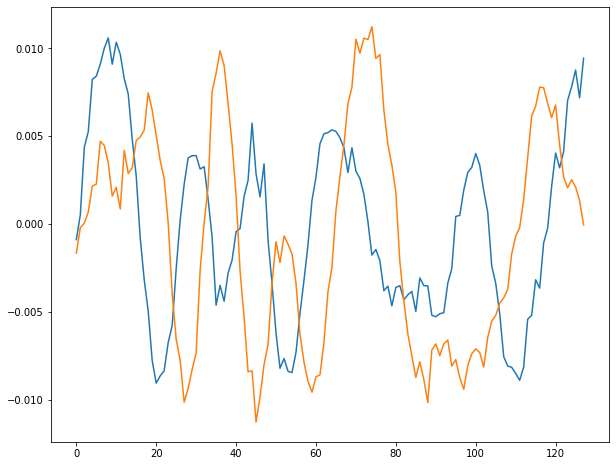

(1, 256, 2, 126)


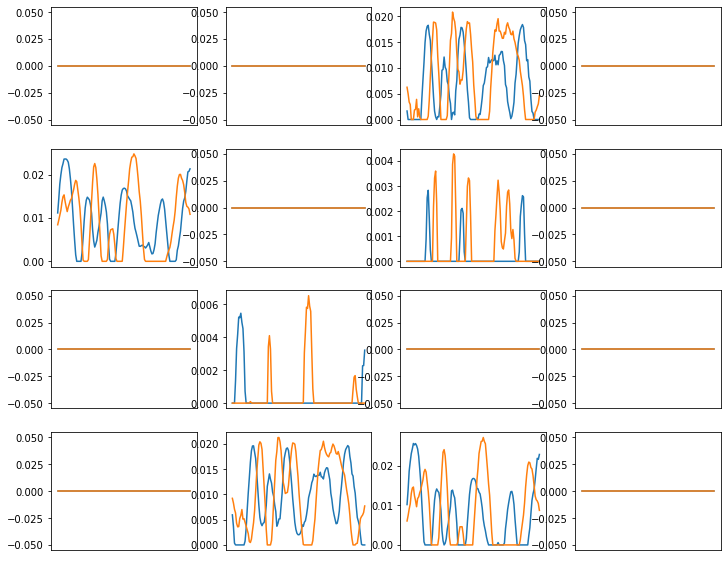

In [ ]:
# redefine model to output right after the first hidden layer
model = cnn_model
ixs = [1]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)

samp = 88 #arbitrary
sig = X_train[samp] #choose signal to run through the model
label = labels_train[samp]
print(label)
plt.plot(sig[0])
plt.plot(sig[1])
plt.show()

feature_maps = model.predict(sig.reshape(1, 2, 128))
print(feature_maps.shape)

# plot the output from each block
ix = 1
shift = 32
plt.subplots(square, square, figsize=(12, 10))
for _ in range(square):
  for __ in range(square):
    # specify subplot and turn of axis
    ax = plt.subplot(square, square, ix)
    ax.set_xticks([])
    #ax.set_yticks([])
    # plot filter channel in grayscale
    plt.plot(feature_maps[0, ix-1 + shift, 0, :])
    plt.plot(feature_maps[0, ix-1 + shift, 1, :])
    ix += 1
  # show the figure
plt.show()

A lot of the filter outputs are actually flat due to relu activation. But we can see that some of the outputs are smoother versions of the input, maybe it suggests that some form of denoising is happening in the first convolutional layer.

There is also some scaling of the input. Inversion also occurs.

Overall quite difficult to tell what is happening or why convolutional layers work beyond smoothing and denoising.

## Inception modules
From: [Deep Architectures for Modulation Recognition](https://arxiv.org/abs/1703.09197)

One inception module used, filter sizes of (1,1), (1,8), (1,3). Theory is that instead of having a deep network, we have a wide network consisting of mulitple convolutional layers with different filter sizes concatenated together. Paper didn't find much improvement with inception modules stacked.

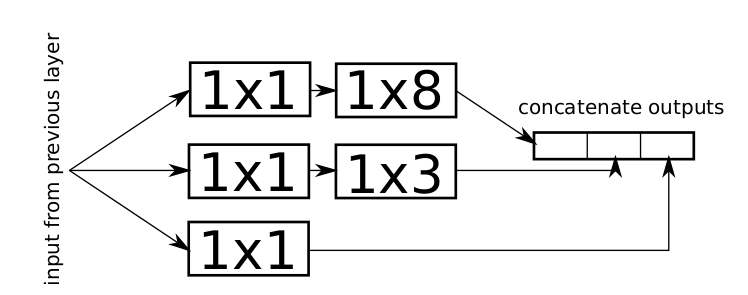

In [ ]:
def build_cnn_inc_net(X1,X2):
  reg = 1e-3
  dropout = 0.4

  input_sh = Input(shape=(X1, X2))
  reshape = Reshape((1,X1,X2))(input_sh)
  
  tower_1 = Convolution2D(50, (1,1), padding='same', activation='relu')(reshape)
  tower_1 = Convolution2D(50, (1,8), padding='same', activation='relu')(tower_1)
  tower_1 = BatchNormalization()(tower_1)

  tower_2 = Convolution2D(50, (1,1), padding='same', activation='relu')(reshape)
  tower_2 = Convolution2D(50, (1,3), padding='same', activation='relu')(tower_2)
  tower_2 = BatchNormalization()(tower_2)
  
  tower_3 = Convolution2D(50, (1,1), padding='same', activation='relu')(reshape)
  
  tower_out = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
  tower_out = Flatten()(tower_out)
  tower_out = Dropout(rate=dropout)(tower_out)
    
  dense1 = Dense(256, activation='relu',kernel_regularizer=regularizers.l1(reg))(tower_out)
  out    = Dense(NUM_CLASSES, activation='softmax')(dense1)
  
  cnn_inc_model = Model(inputs = input_sh, outputs = out)
  
  cnn_inc_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_inc_model.summary()
  return cnn_inc_model

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 2, 128)       0                                            
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 1, 2, 128)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 2, 50)     6450        reshape_7[0][0]                  
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 1, 2, 50)     6450        reshape_7[0][0]                  
____________________________________________________________________________________________

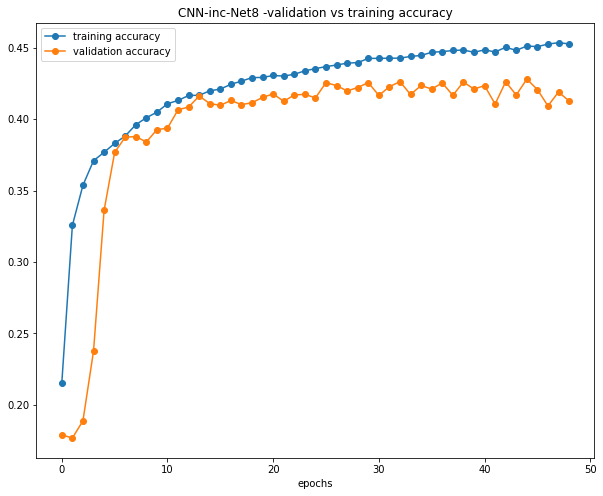

None

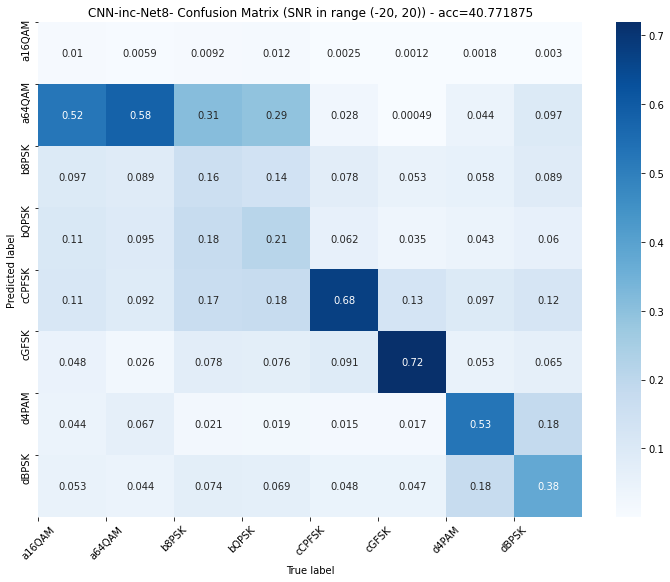

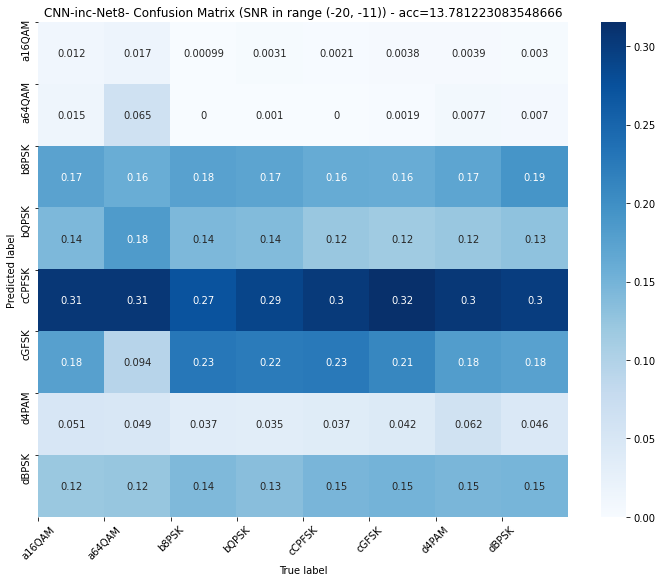

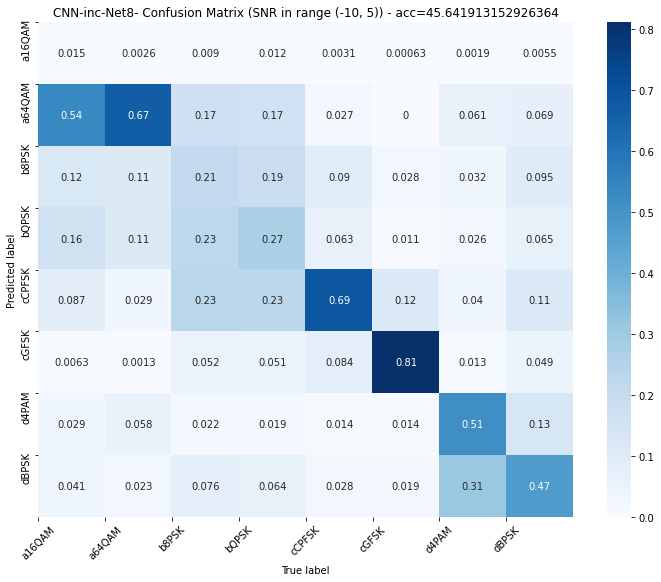

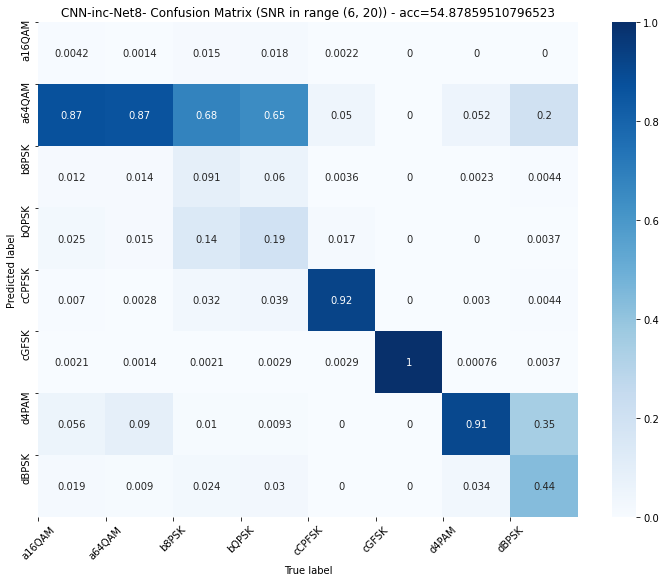

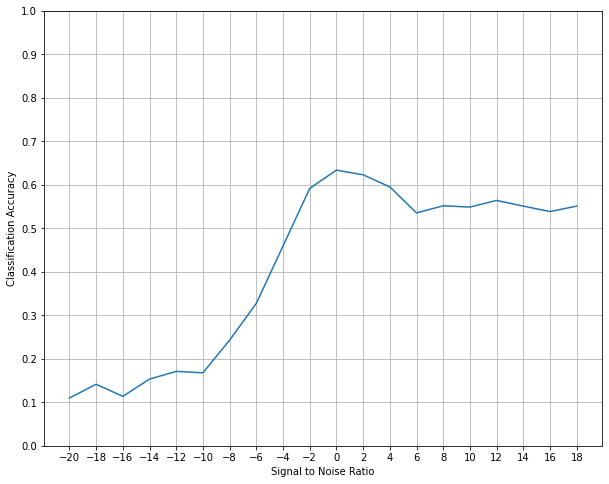

In [ ]:
cnn_inc_model = build_cnn_inc_net(X_test.shape[1], X_test.shape[2])
cnn_inc_model_evaluater = ModelEvaluater(cnn_inc_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE,  'CNN-inc-Net8' )
cnn_inc_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cnn_inc_model_evaluater.print_summary()

This performs worse than a basic CNN. Let's see what happens when we stack another inception module.

### Stack 2 inception modules together

In [ ]:
 def build_cnn_inc2_net(X1,X2):
  reg = 1e-3
  dropout = 0.4

  input_sh = Input(shape=(X1, X2))
  reshape = Reshape((1,X1,X2))(input_sh)
  
  #inception module 1
  tower_1 = Convolution2D(50, (1,1), padding='same', activation='relu')(reshape)
  tower_1 = Convolution2D(50, (1,8), padding='same', activation='relu')(tower_1)
  tower_1 = BatchNormalization()(tower_1)

  tower_2 = Convolution2D(50, (1,1), padding='same', activation='relu')(reshape)
  tower_2 = Convolution2D(50, (1,3), padding='same', activation='relu')(tower_2)
  tower_2 = BatchNormalization()(tower_2)
  
  tower_3 = Convolution2D(50, (1,1), padding='same', activation='relu')(reshape)
  
  tower_out = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

  #inception module 2
  tower_1 = Convolution2D(50, (1,1), padding='same', activation='relu')(tower_out)
  tower_1 = Convolution2D(50, (1,8), padding='same', activation='relu')(tower_1)
  tower_1 = BatchNormalization()(tower_1)

  tower_2 = Convolution2D(50, (1,1), padding='same', activation='relu')(tower_out)
  tower_2 = Convolution2D(50, (1,3), padding='same', activation='relu')(tower_2)
  tower_2 = BatchNormalization()(tower_2)
  
  tower_3 = Convolution2D(50, (1,1), padding='same', activation='relu')(tower_out)

  tower_out = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
  tower_out = Flatten()(tower_out)
  tower_out = Dropout(rate=dropout)(tower_out)
    
  dense1 = Dense(256, activation='relu',kernel_regularizer=regularizers.l1(reg))(tower_out)
  out    = Dense(NUM_CLASSES, activation='softmax')(dense1)
  
  cnn_inc_model = Model(inputs = input_sh, outputs = out)
  
  cnn_inc_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_inc_model.summary()
  return cnn_inc_model

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 2, 128)       0                                            
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 1, 2, 128)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 1, 2, 50)     6450        reshape_8[0][0]                  
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 1, 2, 50)     6450        reshape_8[0][0]                  
____________________________________________________________________________________________

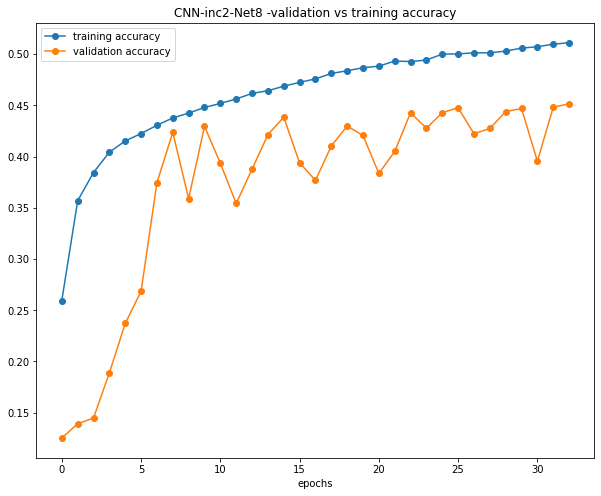

None

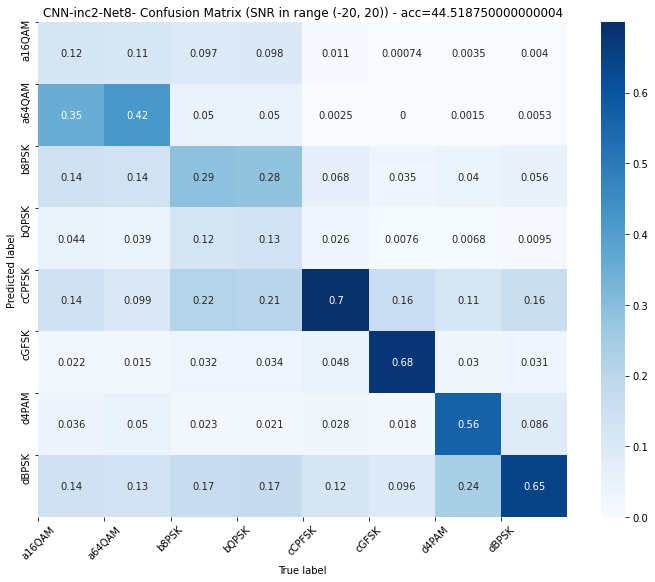

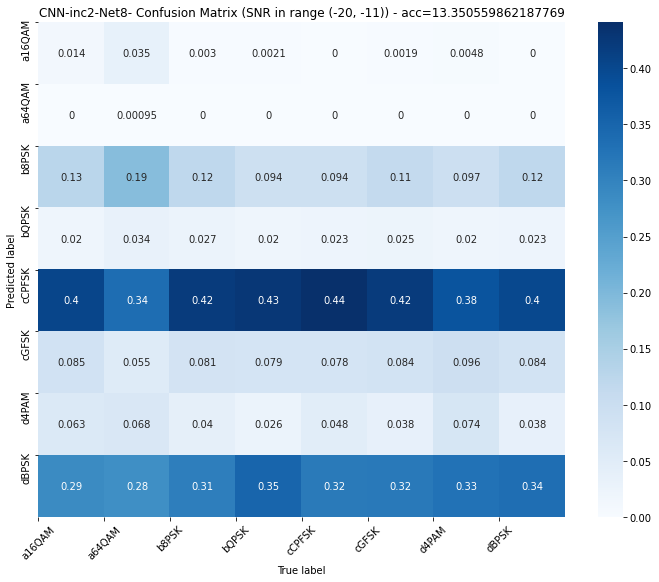

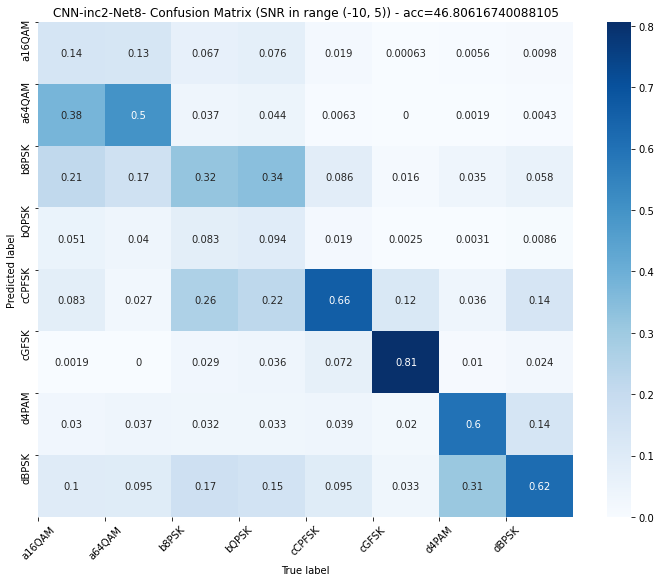

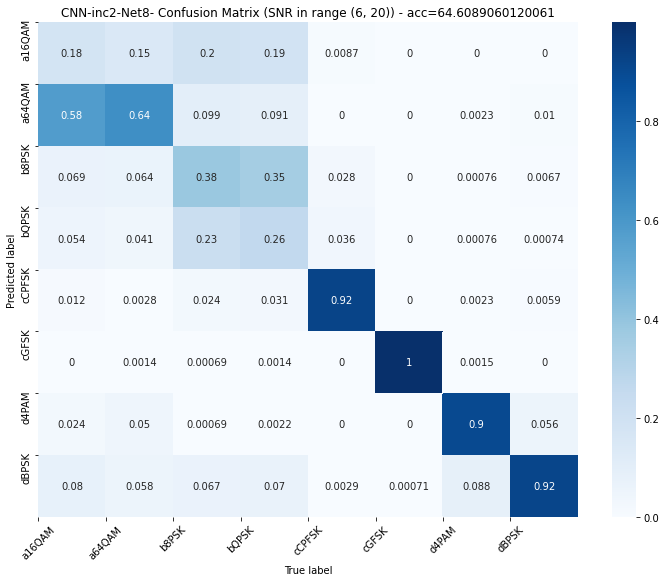

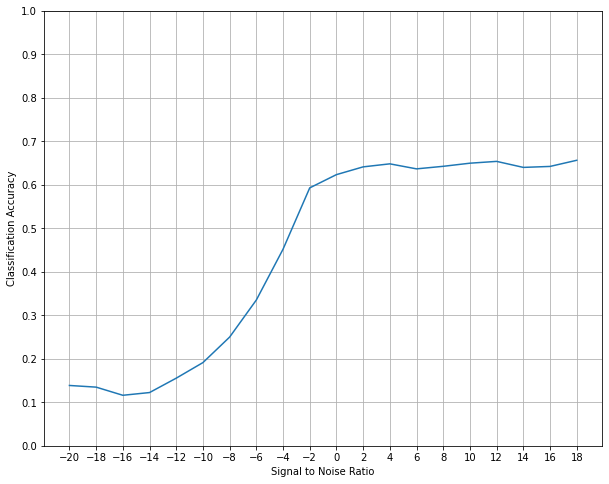

In [ ]:
cnn_inc2_model = build_cnn_inc2_net(X_test.shape[1], X_test.shape[2])
cnn_inc2_model_evaluater = ModelEvaluater(cnn_inc2_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE, 'CNN-inc2-Net8' )
cnn_inc2_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cnn_inc2_model_evaluater.print_summary()

There is slight improvement over one inception module, but it is still much worse than basic convolution nets. Perhaps suggest that different filter sizes (i.e. multiscale approach) is not very helpful for radio time-series signals. Therefore, I am not going to continue with exploring inception architectures.

## Resnet CNN
From [Over-the-Air Deep Learning Based Radio
Signal Classification](https://arxiv.org/pdf/1712.04578.pdf)

Followed: https://medium.com/gsi-technology/residual-neural-networks-in-python-1796a57c2d7 

This CNN is based on ResNet which includes skip connections between convolution layers. Skip connections allow features to operate at multiple scales and depths through the network. This has led to significant improvements for both
CV and time-series audio tasks. 
The network used here contains 5 residual stacks.
In [Over-the-Air Deep Learning Based Radio
Signal Classification](https://arxiv.org/pdf/1712.04578.pdf), it was found that ResNet outperformed all other deep learning models when they tested it on the 2018.01A radioML dataset which had 1024 time-steps per sample.


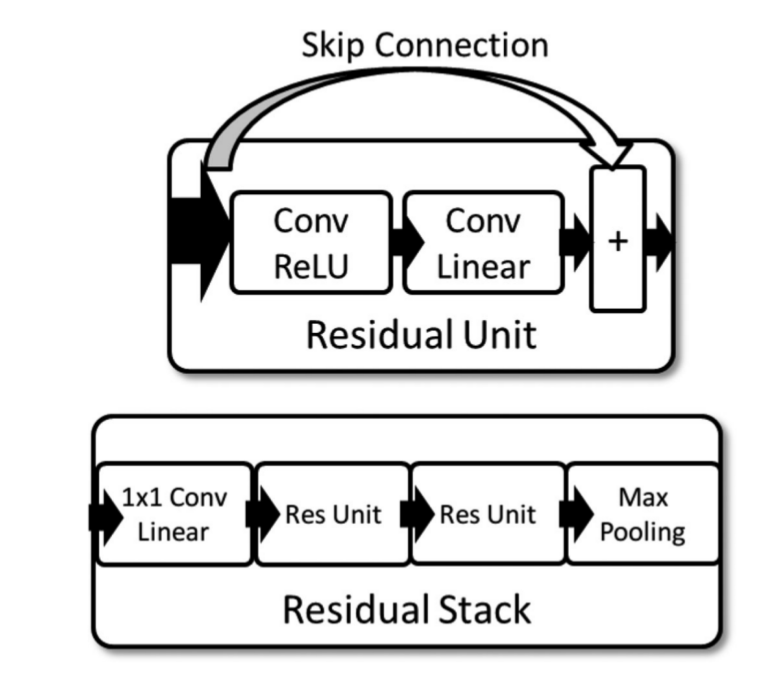

In [ ]:
# 1d conv resnet
def residual_stack(x, f):
    # 1x1 conv linear
    x = Conv1D(f, 1, strides=1, padding='same', data_format='channels_last')(x)
    x = Activation('linear')(x)
    
    # residual unit 1    
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    # add skip connection
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
      
    # residual unit 2    
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides = 1, padding = "same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    # add skip connection
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
      
    # max pooling layer
    x = MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')(x)
    return x

# define resnet model
def build_ResNet(input_shape, classes):   
    # create input tensor
    x_input = Input(input_shape)
    x = x_input
    # residual stack
    num_filters = 40
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    
    # output layer
    x = Flatten()(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(classes , activation='softmax', kernel_initializer = glorot_uniform(seed=0))(x)
    
    # Create model
    model = Model(inputs = x_input, outputs = x)

    adm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)
    model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

### IQ training

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 128, 2)       0                                            
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 128, 40)      120         input_9[0][0]                    
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 128, 40)      0           conv1d_26[0][0]                  
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 128, 40)      4840        activation_32[0][0]              
____________________________________________________________________________________________

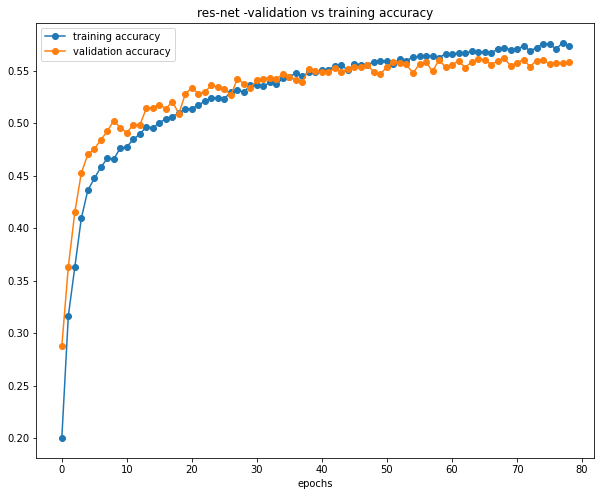

None

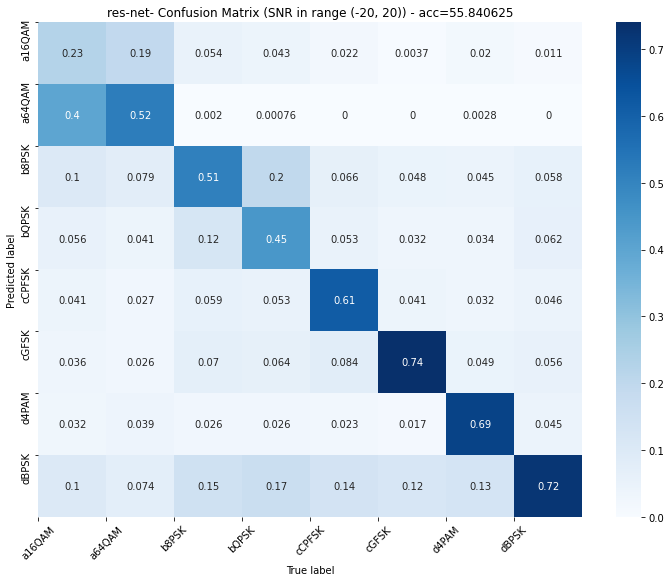

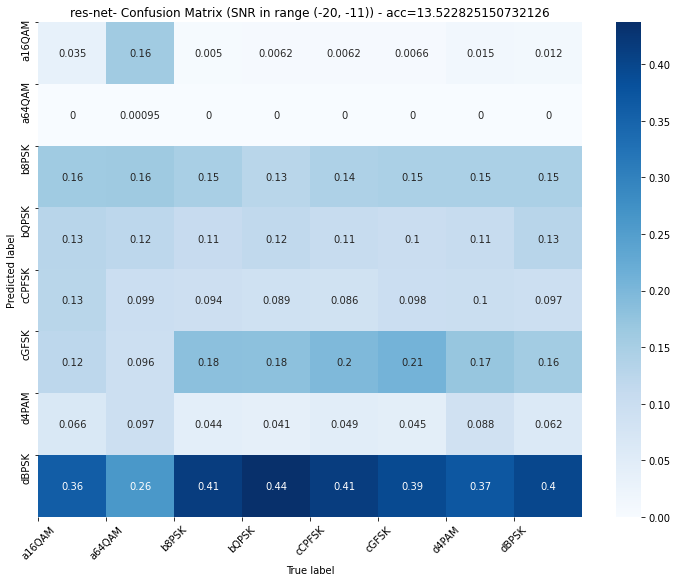

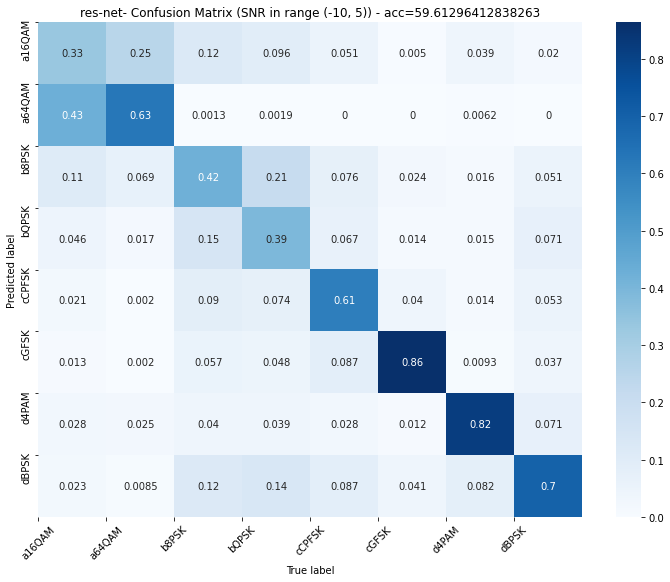

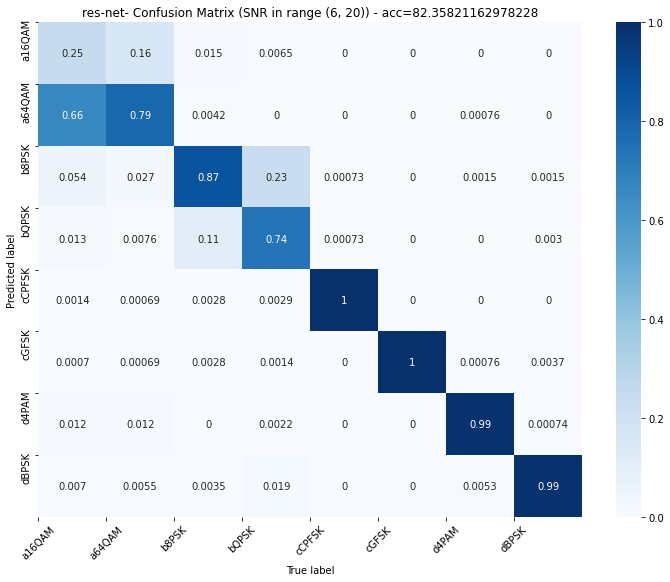

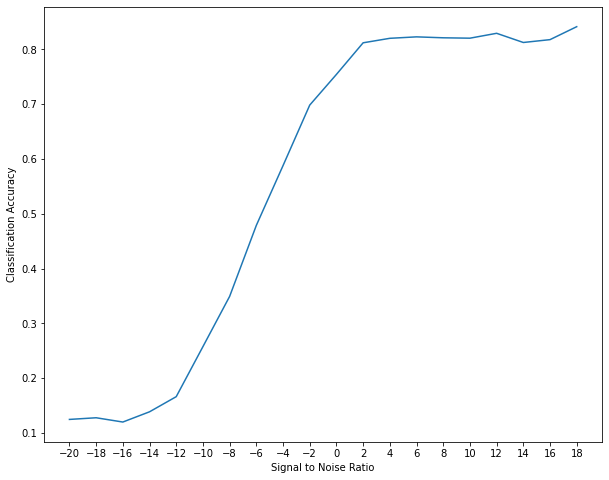

In [ ]:
resnet_model = build_ResNet((X_test.shape[2],X_test.shape[1]), NUM_CLASSES)
resnet_model_evaluater = ModelEvaluater(resnet_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE, 'res-net', channels_first=False)
resnet_model_evaluater.fit(EPOCHS, patience=PATIENCE)
resnet_model_evaluater.print_summary()

Resnet performs only slightly better than the basic CNN and is still confused over QAMs and PSKs, but it also trains much faster because of the skip connections that allow sharing of parameters across layers.

### AP training


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 2)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 128, 40)      120         input_6[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 128, 40)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 128, 40)      4840        activation_4[0][0]               
___________________________________________________________________________________________

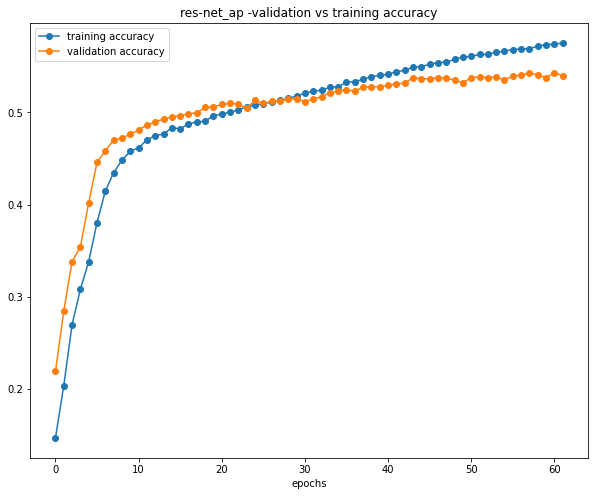

None

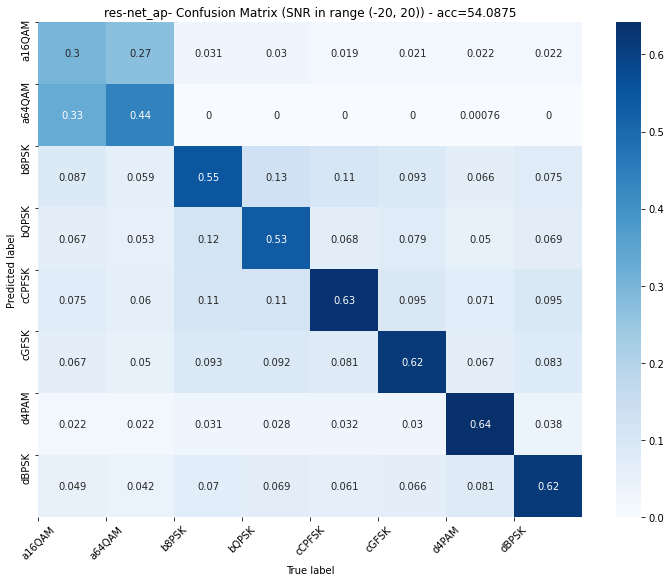

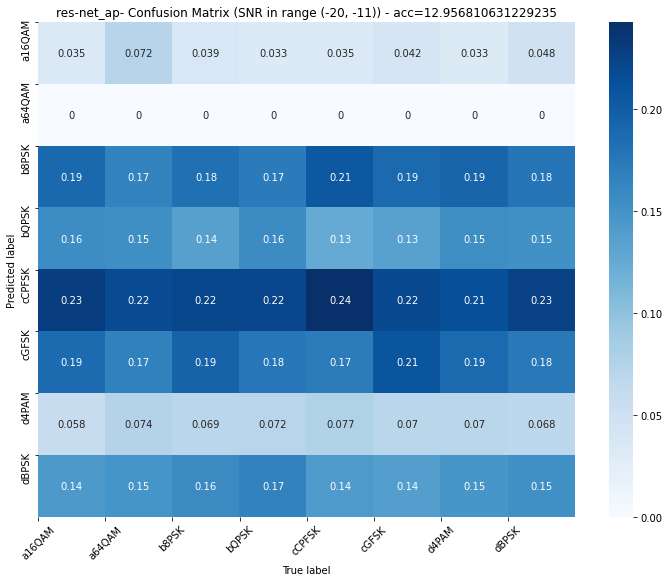

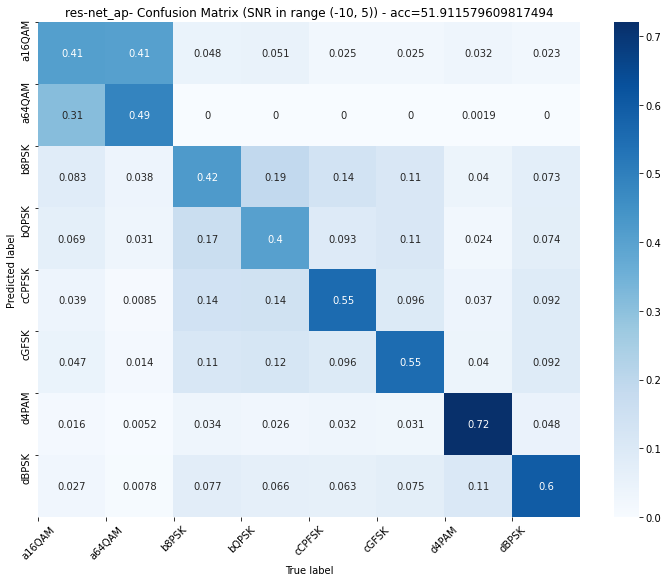

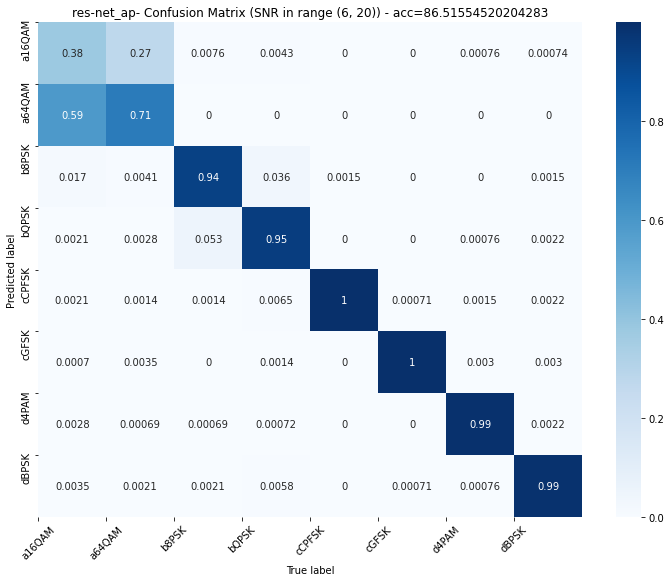

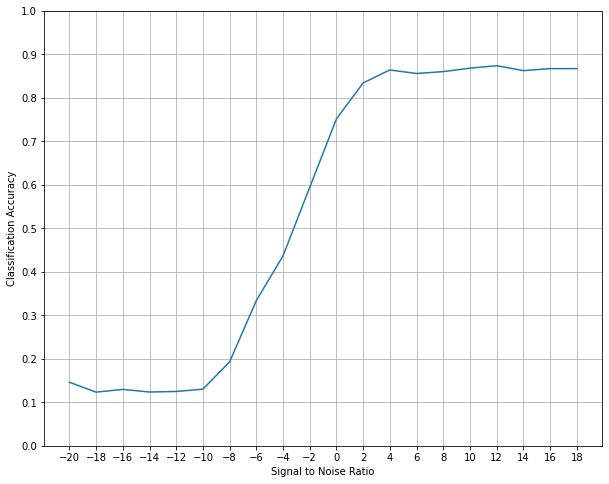

In [ ]:
resnet_ap_model = build_ResNet((X_ap_test.shape[2], X_ap_test.shape[1]), NUM_CLASSES)
resnet_ap_model_evaluater = ModelEvaluater(resnet_ap_model, X_ap_train, y_train, X_ap_val, y_val, X_ap_test, y_test, labels_test, BATCH_SIZE, 'res-net_ap', channels_first=False)
resnet_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
resnet_ap_model_evaluater.print_summary()

Training with amplitude-phase data results in significant improvement in classification accuracy only at high SNR (~4%), and we can see that it is now better at telling apart PSKs but still remains confused over QAMs. However, low and medium SNR performance deteriorates. 

## CLDNN
From: [Deep Architectures for Modulation Recognition](https://arxiv.org/abs/1703.09197)

Convolutional layer followed by LSTM layers, with first convolutional layer output going directly to the LSTM in the last layer. This approach is popular with time-series, with the convolutional layers first removing noise and extracting important features, and the recurrent unit (LSTM) retaining memory of previous elements in the time-series.

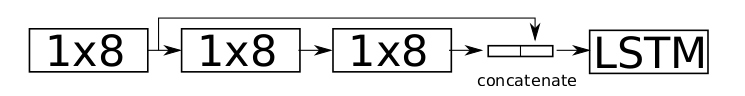

In [ ]:
def build_cldnn_net(X1, X2):
  dr = 0.5  # dropout rate l

  # Reshape [N,2,128] to [N,1,2,128] on input
  input_x = Input(shape=(1, X1, X2))

  # channels_first corresponds to inputs with shape (batch, channels, height, width).
  # Build our model
  input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

  layer1 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv1", init='glorot_uniform', data_format="channels_first")(input_x_padding)
  layer1 = Dropout(dr)(layer1)
  layer1_padding = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

  layer2 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", init='glorot_uniform', data_format="channels_first")(layer1_padding)
  layer2 = Dropout(dr)(layer2)
  layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

  layer3 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv3", init='glorot_uniform', data_format="channels_first")(layer2)
  layer3 = Dropout(dr)(layer3)

  concat = keras.layers.concatenate([layer1, layer3])
  concat_size = list(np.shape(concat))
  input_dim = int(concat_size[-1] * concat_size[-2])
  timesteps = int(concat_size[-3])
  concat = Reshape((timesteps, input_dim))(concat)
  lstm_out = LSTM(50, input_dim=input_dim, input_length=timesteps)(concat)
  layer_dense1 = Dense(256, activation='relu', init='he_normal', name="dense1")(lstm_out)
  layer_dropout = Dropout(dr)(layer_dense1)
  layer_dense2 = Dense(NUM_CLASSES, init='he_normal', name="dense2")(layer_dropout)
  layer_softmax = Activation('softmax')(layer_dense2)

  output = Reshape([NUM_CLASSES])(layer_softmax)
  model = Model(inputs=input_x, outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

### IQ training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 1, 2, 132)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

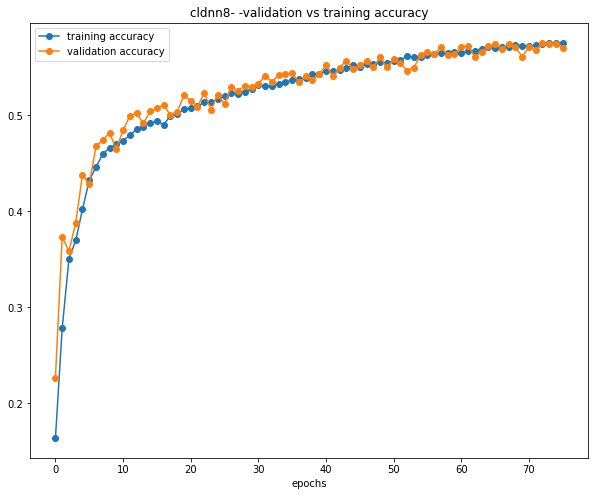

None

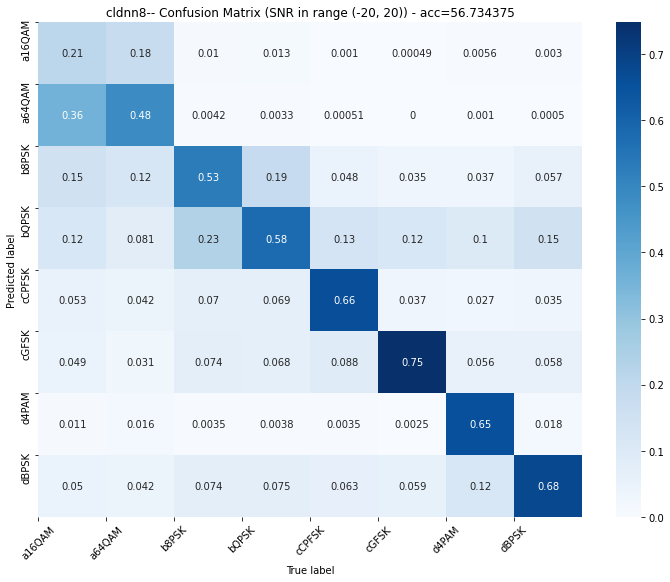

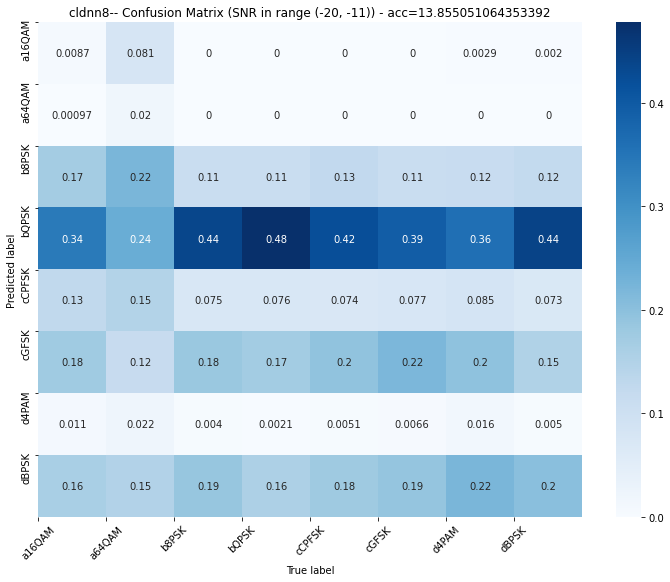

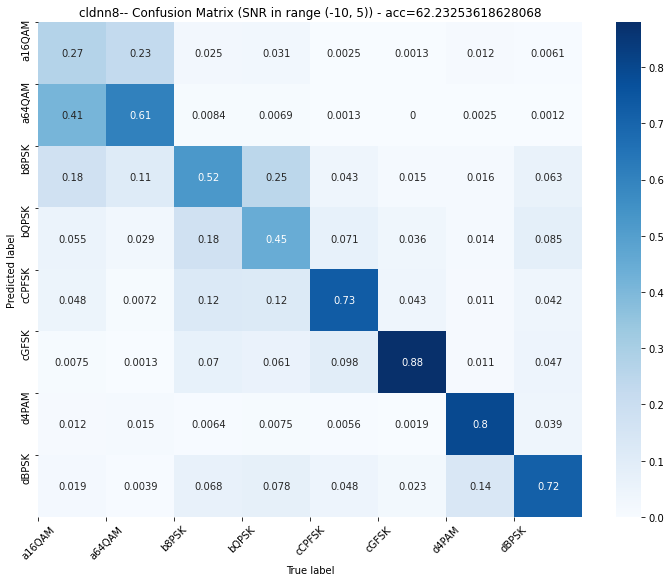

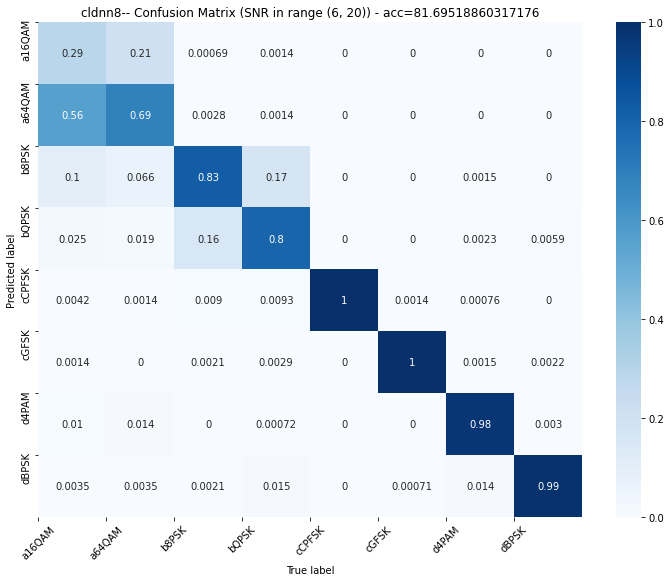

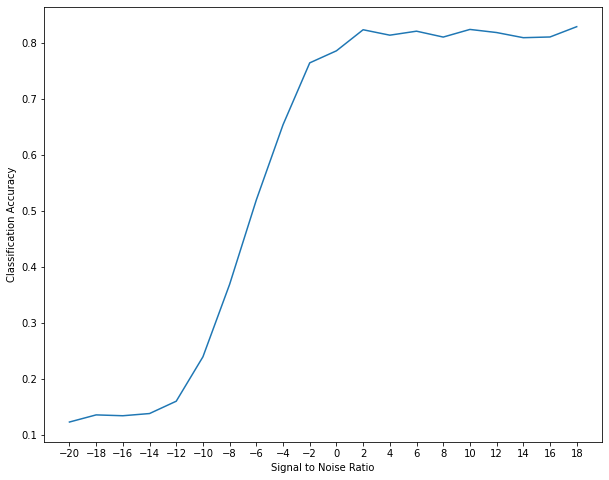

In [ ]:
#Need to reshape I/Q data from 3D into 4D to input into model
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

cldnn_model = build_cldnn_net(X_test.shape[1], X_test.shape[2])
cldnn_model_evaluater = ModelEvaluater(cldnn_model, X_train2, y_train,X_val2, y_val, X_test2, y_test, labels_test, BATCH_SIZE, 'cldnn8-' )
cldnn_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cldnn_model_evaluater.print_summary()

CLDNN performs comparably with the basic CNN architecture, but has much fewer parameters and train a lot faster. It is also still confused over QAMs and PSKs. 

### AP Training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 1, 2, 132)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

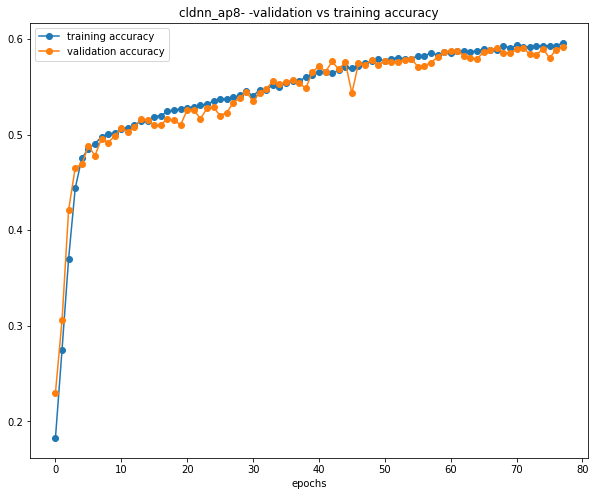

None

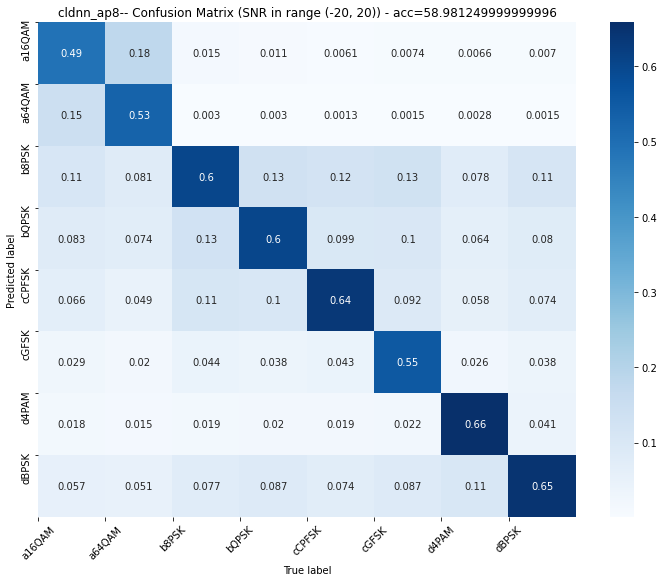

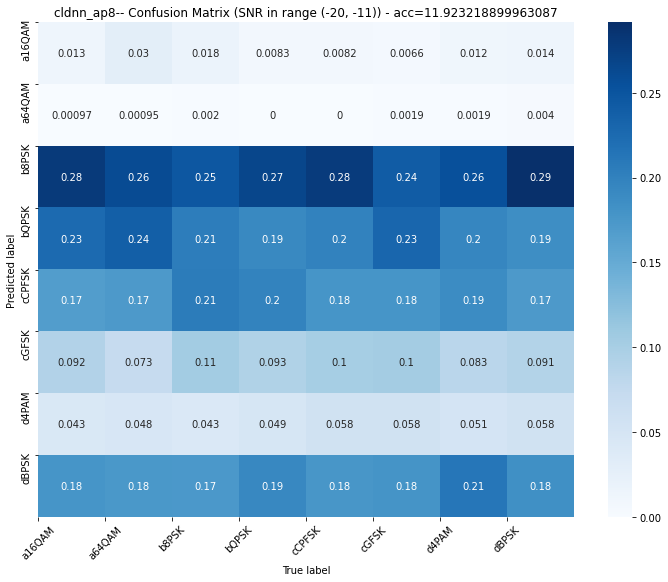

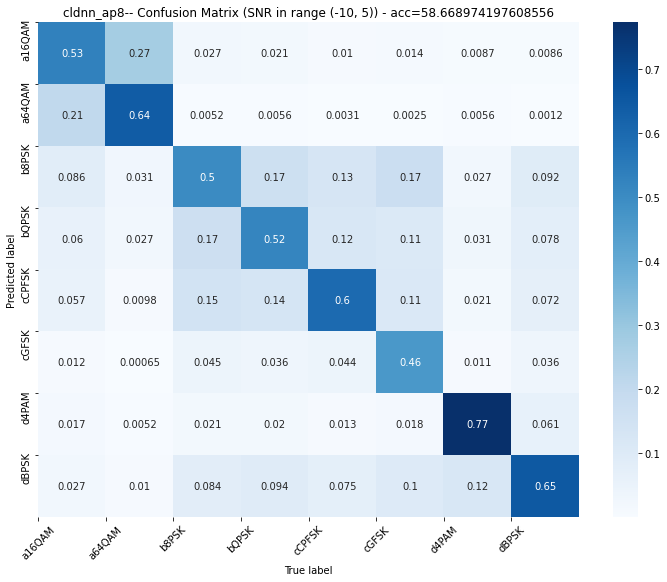

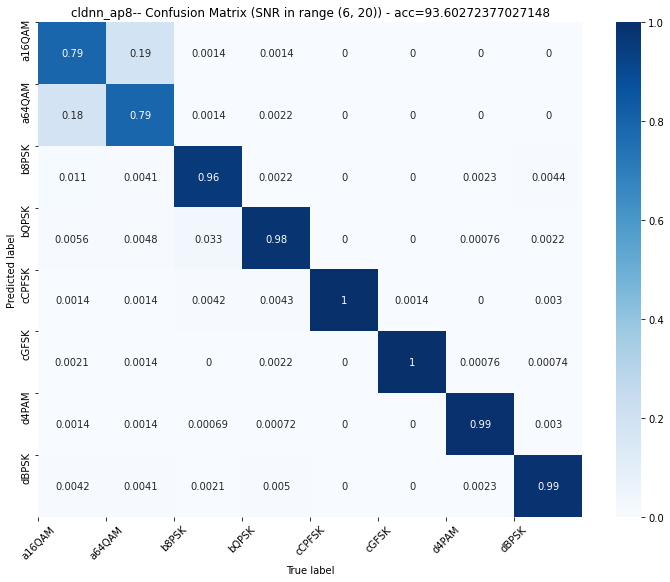

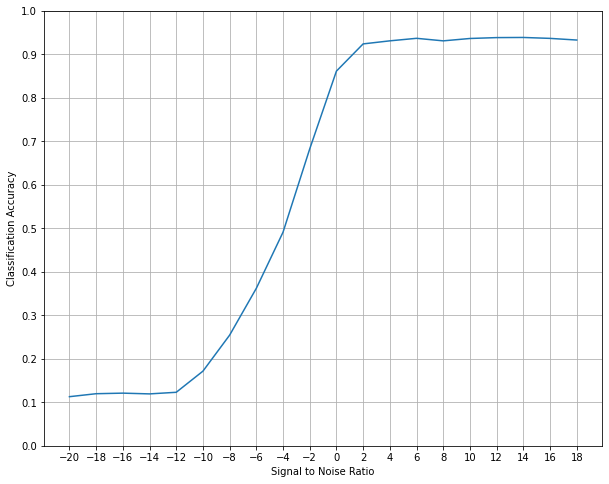

In [ ]:
#Need to reshape I/Q data from 3D into 4D to input into model
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])

cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_train2, y_train, X_ap_val2, y_val, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'cldnn_ap8-' )
cldnn_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cldnn_ap_model_evaluater.print_summary()

Training with amplitude-phase data has greatly improved high SNR performance by more than 10%, with PSKs almost being perfectly distinguished, and QAMs distinguishability much improved. However, medium and low SNR performance have deteriorated greatly.

## Simple LSTM
In [Deep Learning Models for Wireless Signal Classification with Distributed Low-Cost Spectrum Sensors](https://arxiv.org/pdf/1707.08908.pdf), 2-layer LSTM has been shown to work quite well for amplitude-phase time-series as it is able to retain memory of previous elements when capturing patterns in the data.

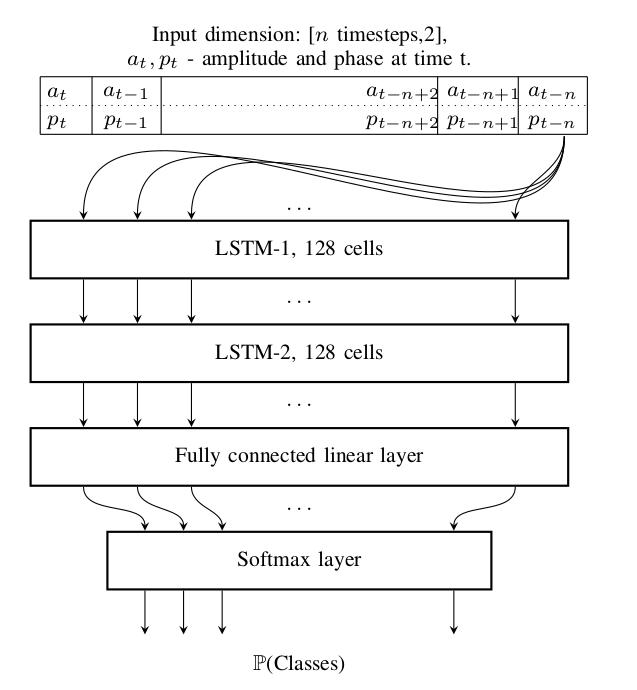

In [ ]:
def build_lstm_net(X1, X2):
  model = Sequential()
  model.add(LSTM(X2, input_shape=(X2, X1), return_sequences=True, name='lstm1', dropout=1.0, recurrent_dropout=0.8))
  model.add(LSTM(X2, name='lstm2', dropout=0.8, recurrent_dropout=1.0))
  model.add(Dense(NUM_CLASSES, activation='softmax', name='dense1'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

### IQ training

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 128, 128)          67072     
_________________________________________________________________
lstm2 (LSTM)                 (None, 128)               131584    
_________________________________________________________________
dense1 (Dense)               (None, 8)                 1032      
Total params: 199,688
Trainable params: 199,688
Non-trainable params: 0
_________________________________________________________________
y_train 107200
y_val 20800
y_test 32000
Train on 107200 samples, validate on 20800 samples
Epoch 1/10
107200/107200 [==============================] - 29s 275us/step - loss: 2.0827 - accuracy: 0.1247 - val_loss: 2.0796 - val_accuracy: 0.1251

Epoch 00001: val_loss improved from inf to 2.07959, saving model to /content/gdrive/My Drive/mod_rec/lstm8--weights-1.hdf5
Epoch 2/10
1

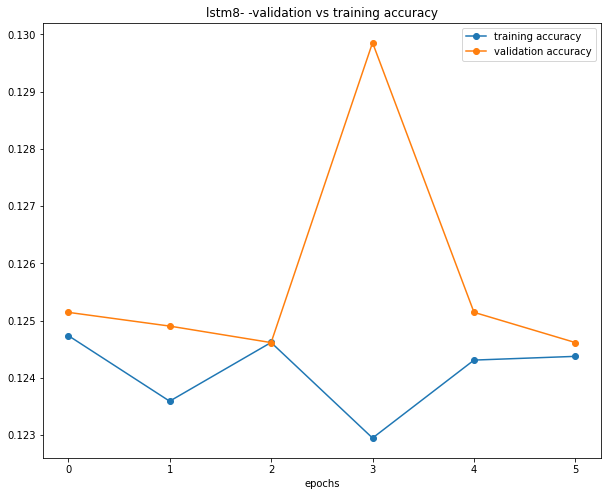

None

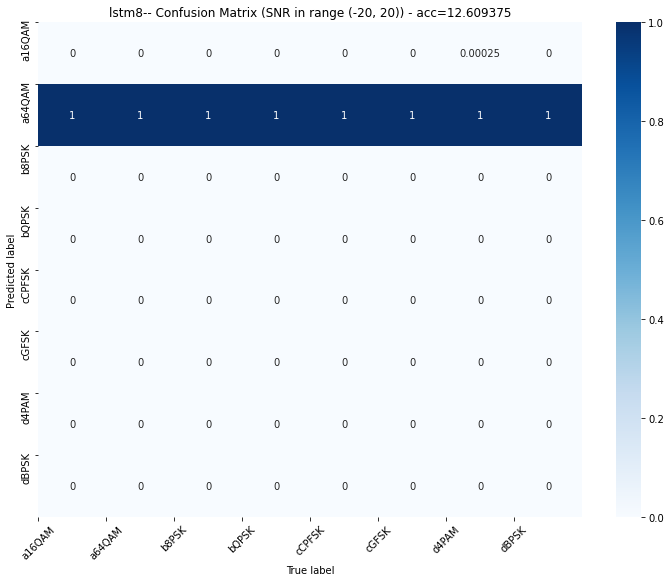

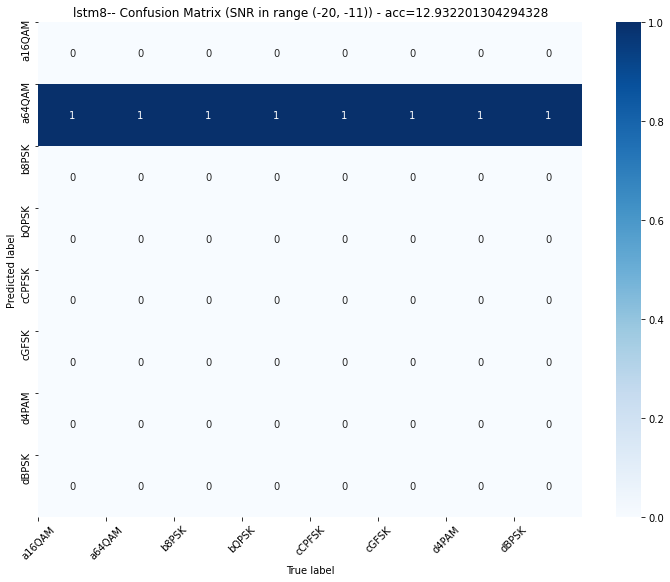

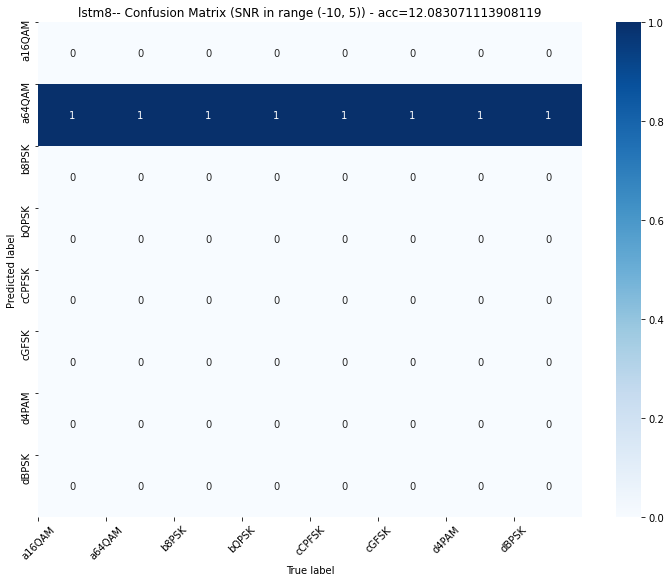

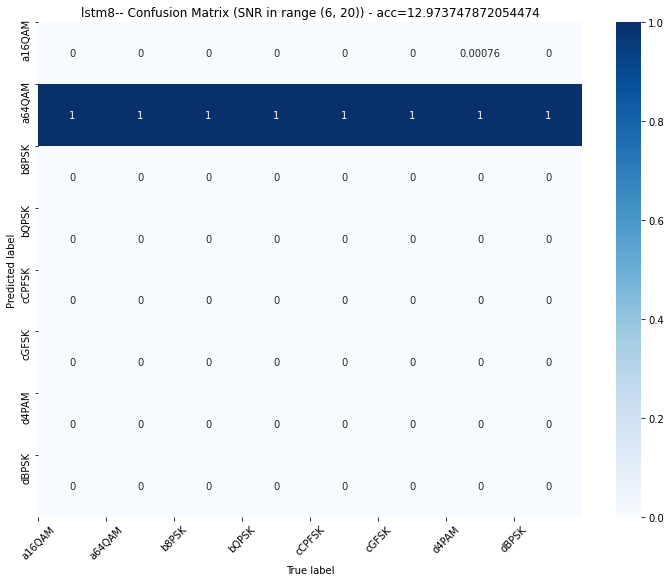

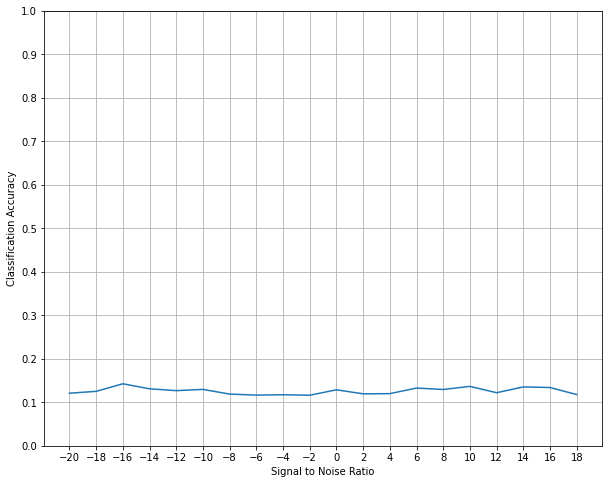

In [ ]:
#Ｎeed to reshape data to fit into lstm model
X_train3 = X_train.reshape(-1, 128, 2)
X_val3 = X_val.reshape(-1, 128, 2)
X_test3 = X_test.reshape(-1, 128, 2)

lstm_model = build_lstm_net(X_train.shape[1], X_train.shape[2])
lstm_model_evaluater = ModelEvaluater(lstm_model, X_train3, y_train, X_val3, y_val, X_test3, y_test, labels_test, BATCH_SIZE, 'lstm8-' )
lstm_model_evaluater.fit(10, patience=2)
lstm_model_evaluater.print_summary()

IQ time series doesn't seem to work at all for LSTMs. This is surprising since there is definitely a temporal pattern in the IQ time-series. Might be some error in the code I haven't figured out. Since the paper showed that amplitude-phase data works, let's try that next.

### AP training

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 128, 128)          67072     
_________________________________________________________________
lstm2 (LSTM)                 (None, 128)               131584    
_________________________________________________________________
dense1 (Dense)               (None, 8)                 1032      
Total params: 199,688
Trainable params: 199,688
Non-trainable params: 0
_________________________________________________________________
y_train 107200
y_val 20800
y_test 32000
Train on 107200 samples, validate on 20800 samples
Epoch 1/100
107200/107200 [==============================] - 27s 251us/step - loss: 2.0045 - accuracy: 0.1748 - val_loss: 1.9295 - val_accuracy: 0.2065

Epoch 00001: val_loss improved from inf to 1.92955, saving model to /content/gdrive/My Drive/mod_rec/lstm_ap8--weights-1.hdf5
Epoch 2/

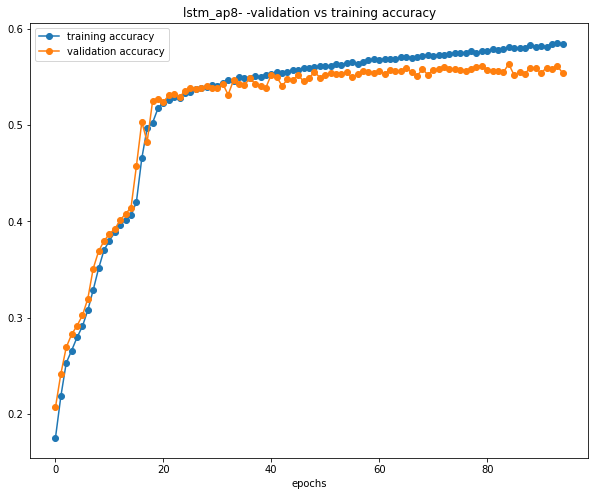

None

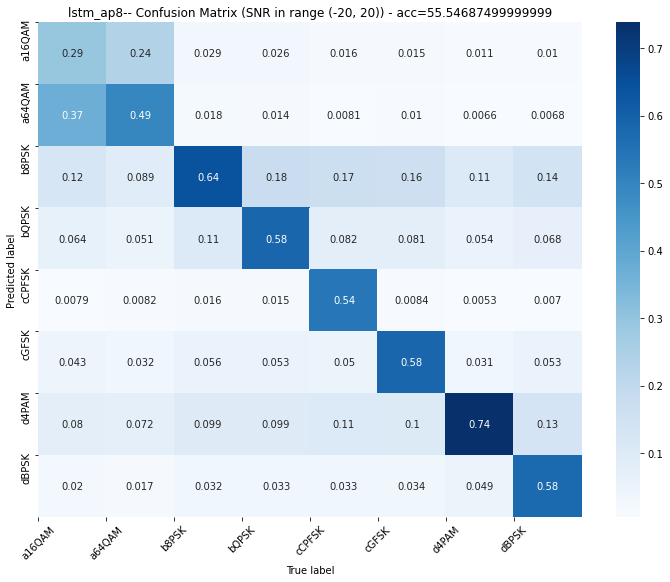

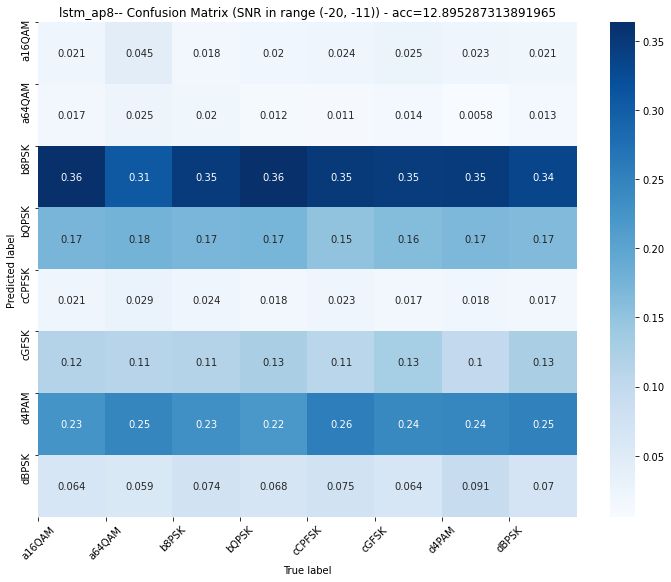

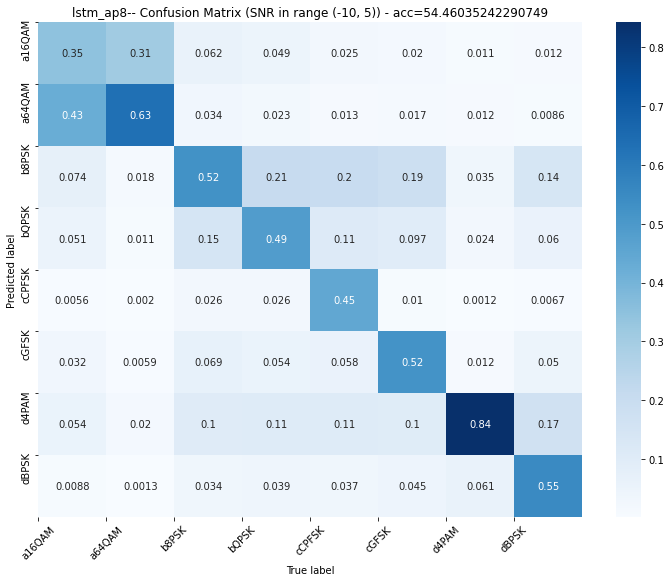

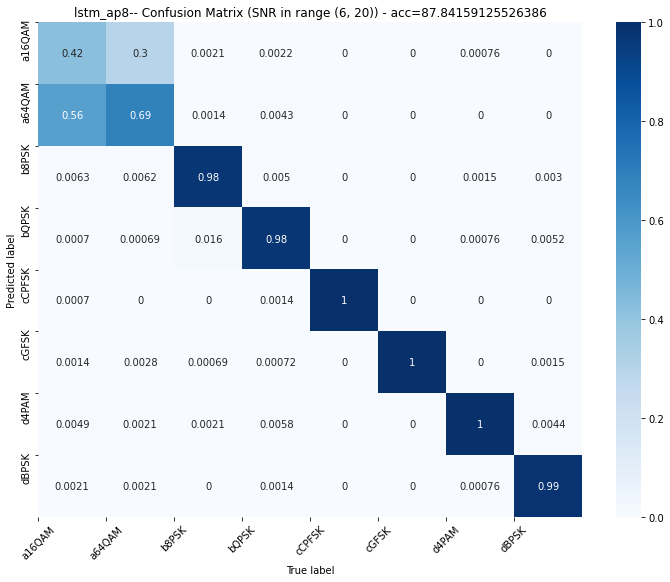

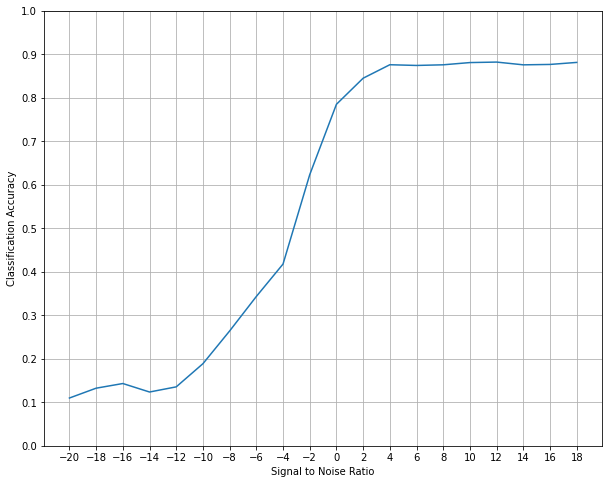

In [ ]:
#Ｎeed to reshape data to fit into lstm model
X_ap_train3 = X_ap_train.reshape(-1, 128, 2)
X_ap_val3 = X_ap_val.reshape(-1, 128, 2)
X_ap_test3 = X_ap_test.reshape(-1, 128, 2)

lstm_ap_model = build_lstm_net(X_ap_train.shape[1], X_ap_train.shape[2])
lstm_ap_model_evaluater = ModelEvaluater(lstm_ap_model, X_ap_train3, y_train, X_ap_val3, y_val, X_ap_test3, y_test, labels_test, BATCH_SIZE, 'lstm_ap8-' )
lstm_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
lstm_ap_model_evaluater.print_summary()

LSTM performs very well on the amplitude-phase data, slightly better than cnn_ap, even without convolutional layers in front!

# Insights and conclusion
Here, we do an overall comparison and conclude which is the best model and best feature.

In [ ]:
cnn_model = build_cnn_net(X_test.shape[1], X_test.shape[2])
cnn_model.load_weights(root_path + 'weights/CNN-Net8-weights-59.hdf5')
cnn_model_evaluater = ModelEvaluater(cnn_model, X_test, y_test, X_test, y_test, X_test, y_test, labels_test, BATCH_SIZE, 'CNN-Net8' )
cnn_accpersnr = cnn_model_evaluater.accpersnr_model()

cnn_ap_model = build_cnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cnn_ap_model.load_weights(root_path + 'weights/CNN-Net_ap8-weights-54.hdf5')
cnn_ap_model_evaluater = ModelEvaluater(cnn_ap_model, X_ap_test, y_test, X_ap_test, y_test, X_ap_test, y_test, labels_test, BATCH_SIZE, 'CNN-Net_ap8' )
cnn_ap_accpersnr = cnn_ap_model_evaluater.accpersnr_model()

resnet_model = build_ResNet((X_test.shape[2],X_test.shape[1]), NUM_CLASSES)
resnet_model.load_weights(root_path + 'weights/res-net8-weights-69.hdf5')
resnet_model_evaluater = ModelEvaluater(resnet_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE, 'res-net', channels_first=False)
resnet_accpersnr = resnet_model_evaluater.accpersnr_model()

resnet_ap_model = build_ResNet((X_ap_test.shape[2], X_ap_test.shape[1]), NUM_CLASSES)
resnet_ap_model.load_weights(root_path + 'weights/res-net_ap-weights-52.hdf5')
resnet_ap_model_evaluater = ModelEvaluater(resnet_ap_model, X_ap_train, y_train, X_ap_val, y_val, X_ap_test, y_test, labels_test, BATCH_SIZE, 'res-net_ap', channels_first=False)
resnet_ap_accpersnr = resnet_ap_model_evaluater.accpersnr_model()

#Need to reshape I/Q data from 3D into 4D to input into model
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
cldnn_model = build_cldnn_net(X_test.shape[1], X_test.shape[2])
cldnn_model.load_weights(root_path + 'weights/cldnn8--weights-66.hdf5')
cldnn_model_evaluater = ModelEvaluater(cldnn_model, X_test2, y_test,X_test2, y_test, X_test2, y_test, labels_test, BATCH_SIZE, 'cldnn8-' )
cldnn_accpersnr = cldnn_model_evaluater.accpersnr_model()

#Need to reshape I/Q data from 3D into 4D to input into model
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model.load_weights(root_path + 'weights/cldnn_ap8--weights-68.hdf5')
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_test2, y_test, X_ap_test2, y_test, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'cldnn_ap8-' )
cldnn_ap_accpersnr = cldnn_ap_model_evaluater.accpersnr_model()

#Ｎeed to reshape data to fit into lstm model
X_ap_test3 = X_ap_test.reshape(-1, 128, 2)
lstm_ap_model = build_lstm_net(X_ap_train.shape[1], X_ap_train.shape[2])
lstm_ap_model.load_weights(root_path + 'weights/lstm_ap8--weights-85.hdf5')
lstm_ap_model_evaluater = ModelEvaluater(lstm_ap_model, X_ap_test3, y_test, X_ap_test3, y_test, X_ap_test3, y_test, labels_test, BATCH_SIZE, 'lstm_ap8-' )
lstm_ap_accpersnr = lstm_ap_model_evaluater.accpersnr_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="softmax", kernel_initializer="he_normal")`
  del sys.path[0]


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 2, 126)       1024      
_________________________________________________________________
dropout_27 (Dropout)         (None, 256, 2, 126)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 80, 1, 124)        122960    
_________________________________________________________________
dropout_28 (Dropout)         (None, 80, 1, 124)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 9920)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="softmax", kernel_initializer="he_normal")`
  del sys.path[0]


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 256, 2, 126)       1024      
_________________________________________________________________
dropout_30 (Dropout)         (None, 256, 2, 126)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 80, 1, 124)        122960    
_________________________________________________________________
dropout_31 (Dropout)         (None, 80, 1, 124)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9920)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 1, 2, 132)    0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_13[0][0]          
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_16 (ZeroPadding2 (None, 1, 2, 132)    0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_16[0][0]          
__________________________________________________________________________________________________
dropout_41 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
___________________________________________________________________________________________

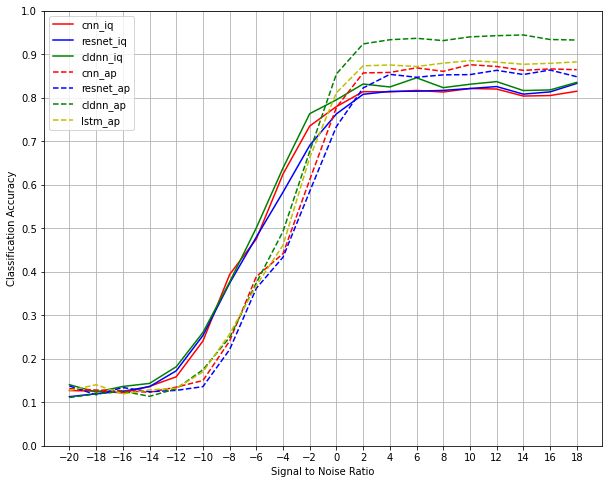

In [ ]:
# plot acc-vs-snr graphs for different models
cnn,  = plt.plot(list(cnn_accpersnr.keys()),list(cnn_accpersnr.values()), 'r-', label='cnn_iq')
resnet,  = plt.plot(list(resnet_accpersnr.keys()),list(resnet_accpersnr.values()), 'b-', label='resnet_iq')
cldnn, = plt.plot(list(cldnn_accpersnr.keys()),list(cldnn_accpersnr.values()), 'g-', label='cldnn_iq')

cnn_ap,  = plt.plot(list(cnn_ap_accpersnr.keys()),list(cnn_ap_accpersnr.values()), 'r--', label='cnn_ap')
resnet_ap,  = plt.plot(list(resnet_ap_accpersnr.keys()),list(resnet_ap_accpersnr.values()), 'b--', label='resnet_ap')
cldnn_ap, = plt.plot(list(cldnn_ap_accpersnr.keys()),list(cldnn_ap_accpersnr.values()), 'g--', label='cldnn_ap')
lstm_ap, = plt.plot(list(lstm_ap_accpersnr.keys()),list(lstm_ap_accpersnr.values()), 'y--', label='lstm_ap')

plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.xticks(list(cnn_accpersnr.keys()))
plt.legend(handles = [cnn, resnet, cldnn, cnn_ap, resnet_ap, cldnn_ap, lstm_ap])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.show()

CLDNN_AP seems to be the best performing model by far at high SNR.
For IQ time-series, all architectures were quite close in performance, with the CLDNN architecture also performing the best.

## Best architecture: CLDNN
So the best architecture seems to be CLDNN, which uses convolutional layers followed by an LSTM with a skip connection in the middle. This seems to suggest that perhaps if we combine resnet or some other CNN architecture with LSTM at the end, we might also attain good results.

However, it was surprising that ResNet didn't perform better because ResNet achieved close to perfect accuracy over a wider range of more difficult classes in [Over-the-Air Deep Learning Based Radio
Signal Classification](https://arxiv.org/pdf/1712.04578.pdf). Perhaps it is issues with hyperparameter tuning, and also the fact that the paper trained with 2x1024 time-series instead of 2x128.


## Best input feature
Across all models, training with amplitude-phase data improves high SNR accuracy because PSKs were almost perfectly differentiated and QAMs differentiation also improved significantly compared to trainng with IQ data. However, medium and low SNR performance became worse. 

This shows that amplitude-phase time series contains more distinguishing information for each modulation type but is also less resistant to noise. Not sure what will happen if we form a 4x128 input feature, will we combine the advantages and end up with good high SNR performance and also more robust performance at low SNRs?

# Acting on insights: Resnet + LSTM
To prove the point that CNN in the first layers followed by LSTM was the reason for CLDNN's success, I combined the ResNet and LSTM architectures in a similar way to CLDNN, and indeed I achieved slightly better results than CLDNN, with slightly better distinction between the QAMs.

In [ ]:
# 1d conv resnet
def residual_stack(x, f, pool=True):
    # 1x1 conv linear
    x = Conv1D(f, 1, strides=1, padding='same', data_format='channels_last')(x)
    x = Activation('linear')(x)
    
    # residual unit 1    
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    # add skip connection
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
      
    # residual unit 2    
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides = 1, padding = "same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    # add skip connection
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
    
    if pool:
      # max pooling layer
      x = MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')(x)
    return x

# define resnet model
def build_ResNet(input_shape, classes):   
    # create input tensor
    x_input = Input(input_shape)
    x = x_input
    # residual stack
    num_filters = 40
    x1 = residual_stack(x, num_filters, pool=False)
    x2 = residual_stack(x1, num_filters, pool=False)
    x3 = residual_stack(x2, num_filters, pool=False)
    x4 = residual_stack(x3, num_filters)
    x5 = residual_stack(x4, num_filters)

    concat = keras.layers.concatenate([x, x3])
    lstm_out = LSTM(128, input_dim=42, return_sequences=True, input_length=128)(concat)
    lstm_out = LSTM(32, input_dim=1, input_length=128)(lstm_out)
    lstm_out = Reshape((32, 1))(lstm_out)

    concat = keras.layers.concatenate([x5, lstm_out])
    concat = Flatten()(concat)
    layer_dense1 = Dense(256, activation='relu', init='he_normal', name="dense1")(concat)
    layer_dropout = Dropout(0.5)(layer_dense1)
    layer_dense2 = Dense(128, activation='relu', init='he_normal', name="dense2")(layer_dropout)
    layer_dropout = Dropout(0.5)(layer_dense2)
    layer_dense3 = Dense(NUM_CLASSES, init='he_normal', name="dense3")(layer_dropout)
    layer_softmax = Activation('softmax')(layer_dense3)

    output = Reshape([NUM_CLASSES])(layer_softmax)
    model = Model(inputs=x_input, outputs=output)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(128, 42))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, input_shape=(128, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Update your `

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 2)       0                                            
__________________________________________________________________________________________________
conv1d_151 (Conv1D)             (None, 128, 40)      120         input_7[0][0]                    
__________________________________________________________________________________________________
activation_153 (Activation)     (None, 128, 40)      0           conv1d_151[0][0]                 
__________________________________________________________________________________________________
conv1d_152 (Conv1D)             (None, 128, 40)      4840        activation_153[0][0]             
____________________________________________________________________________________________

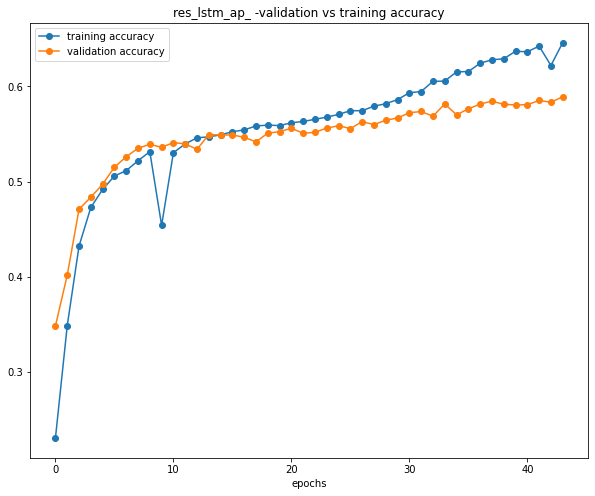

None

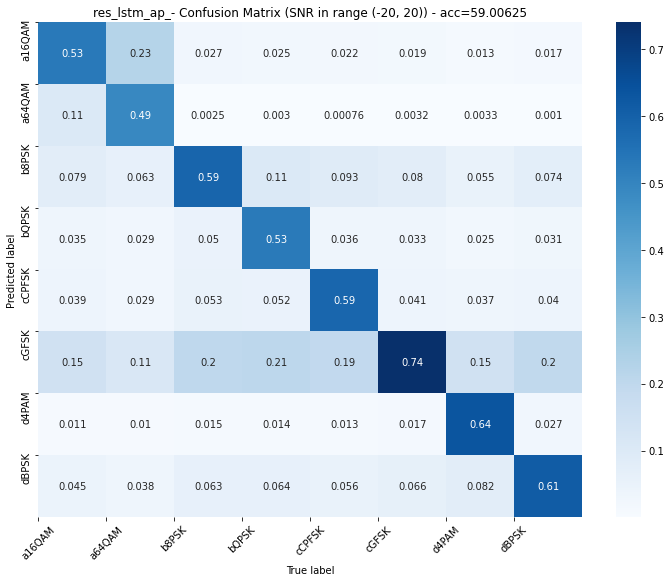

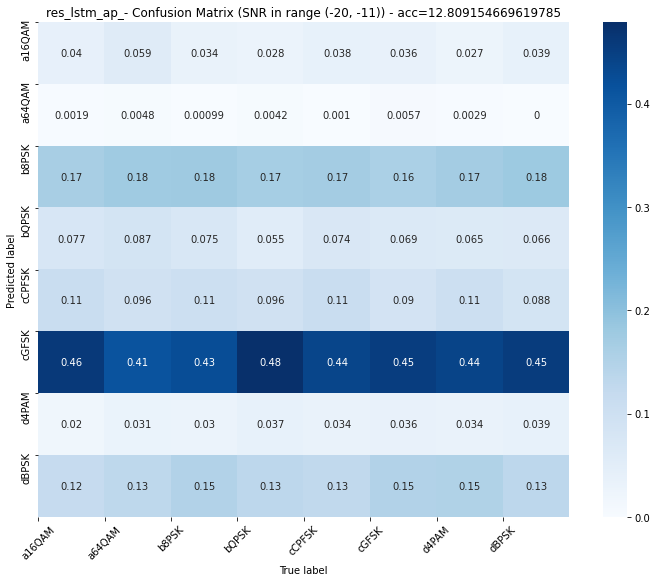

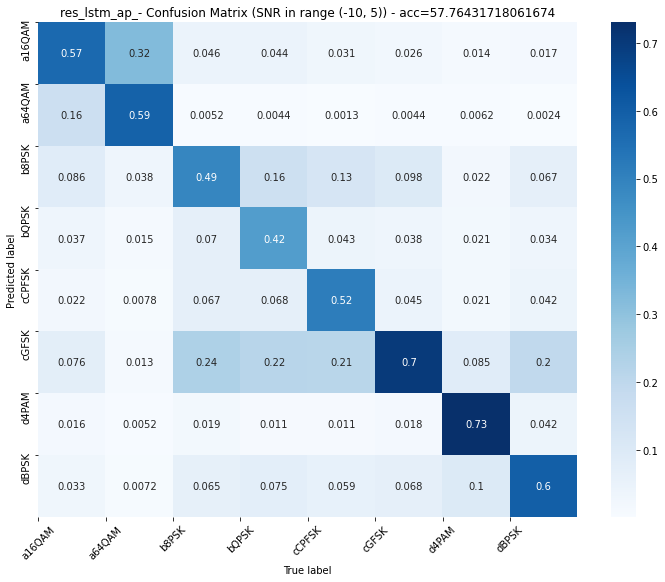

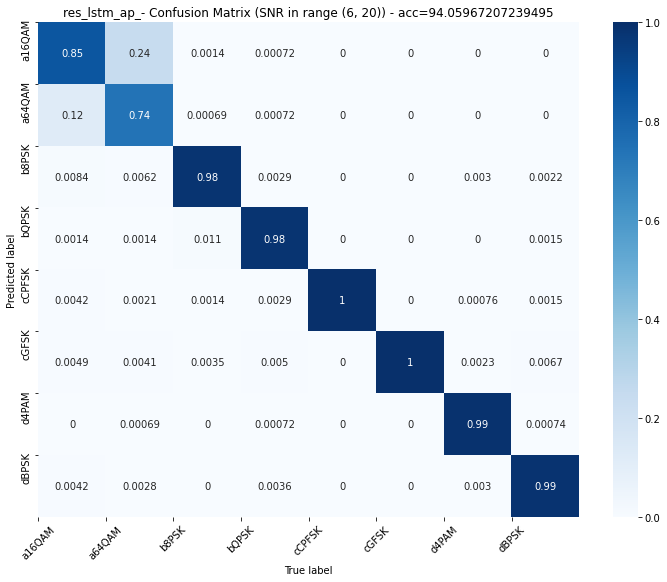

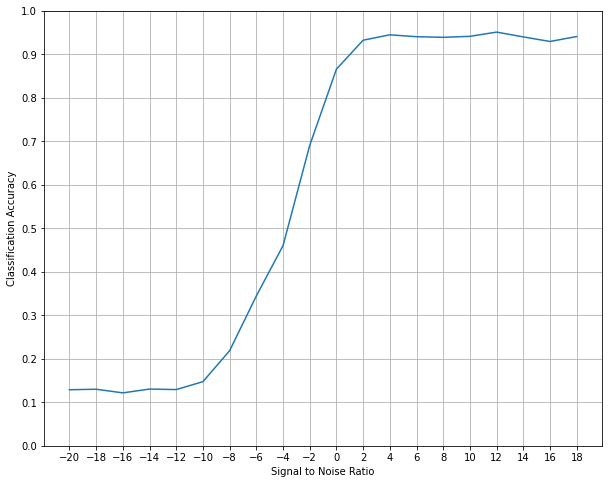

In [ ]:
reslstm_ap_model = build_ResNet((X_ap_test.shape[2], X_ap_test.shape[1]), NUM_CLASSES)
reslstm_ap_model_evaluater = ModelEvaluater(reslstm_ap_model, X_ap_train, y_train, X_ap_val, y_val, X_ap_test, y_test, labels_test, BATCH_SIZE, 'res_lstm_ap_', channels_first=False)
reslstm_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
reslstm_ap_model_evaluater.print_summary()

There is still some confusion between QAMs, and medium SNR performance is still not as good as CLDNN.